# TSC implementation | Experiments with Banana and Funnel

## Libraries

In [1]:
!pip install pyro-ppl normflows flowtorch

In [2]:
!git clone https://github.com/svsamsonov/Practical_task
!mv Practical_task/* .
!rm -r Practical_task

Cloning into 'Practical_task'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 16 (delta 1), reused 6 (delta 0), pack-reused 0
Receiving objects: 100% (16/16), 69.74 KiB | 2.49 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
import pyro
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.distributions import Normal
from torch.distributions import MultivariateNormal as MNormal
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from typing import Optional, List, Tuple, Iterable, Callable, Union
from torch.distributions import Normal, Categorical
from tqdm.notebook import tqdm, trange
from torch import optim
from torch.nn import KLDivLoss
from pyro.infer import HMC as pyro_hmc
from pyro.infer import MCMC
import normflows as nf
from torch.optim.lr_scheduler import StepLR
from distributions import (
    Distribution,
    IndependentNormal
)

In [4]:
!pip install pot #for metrics
# for metrics
import jax
import ot
from metrics import ESS, acl_spectrum
from total_variation import (
    average_total_variation,
)

In [5]:
os.chdir('/')
if not os.path.exists("/tsc_msc_dl"):
    !git clone https://github.com/katyafilimoshina/tsc_msc_dl

## Imports from our GitHub

In [6]:
from tsc_msc_dl.distributions import Funnel, Banana
from tsc_msc_dl.samplers import HMC
from tsc_msc_dl.metrics import compute_metrics
from tsc_msc_dl.plots import visualize_dist_

## TSC implementation (with RealNVP) | Banana



### dim=2

In [52]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 2 # Dimension

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1
BURN_IN = 0
device="cpu"

In [53]:
# Define target and proposal

target = Banana(dim=dim, b=0.02)
proposal = nf.distributions.base.GaussianMixture(n_modes = 2, dim = latent_size, trainable=True)

In [54]:
# Define layers of RealNVP

K = 4
b = torch.Tensor([1] * (latent_size // 2) + [0] * (latent_size // 2))
flows = []
for g in range(K):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    if g % 2 == 0:
      flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
      flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
nfm = nf.NormalizingFlow(proposal, flows, target)

In [55]:
# Define optimizer and scheduler

optimizer_t = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_t = StepLR(optimizer_t, 1, gamma=1e-4)

In [56]:
# Training

torch.manual_seed(296)
n_iter = 3000

# magic params for loss
num_samples = 2 * 10
anneal_iter = 500

loss_arr_dist = []

for i in tqdm(range(n_iter)):

    optimizer_t.zero_grad()

    # Sample a point from warped space
    if i % 50 == 0:
      z_0 = proposal.sample(N_CHAINS).squeeze()

    # Apply HMC to this point in warped space
    chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size = 0.1,
                  num_leapfrog_steps = 10,
                  verbose = False,
                )
    chains = chains.float()
    chains_no_grad = chains.detach().float()

    # Apply RealNVP to the chain and get the final sample
    z = nfm.forward(chains_no_grad)

    if (i % 99 == 0):
      print("Scale:", proposal.log_scale)
      print("Loc:", proposal.loc)

    # Calculate loss
    loss_t = nfm.reverse_kld(num_samples, beta=np.min([1., 0.01 + i / anneal_iter]))
    loss_t.backward(retain_graph=True)

    # Return back to warped space
    z_0 = nfm.inverse(z).squeeze()
    optimizer_t.step()

    loss_arr_dist.append(loss_t.detach().item())

  0%|          | 0/3000 [00:00<?, ?it/s]

Sample: 100%|██████████| 1/1 [00:00, 21.49it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[0., 0.],
         [0., 0.]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.9838, -1.9474],
         [-0.2918, -0.2999]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 47.43it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[0.0582, 0.0404],
         [0.0993, 0.0847]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0081, -2.0017],
         [-0.2120, -0.2451]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 75.06it/s, step size=1.60e+00, acc. prob=0.702]


Scale: Parameter containing:
tensor([[[0.0532, 0.0277],
         [0.1698, 0.1124]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0100, -1.9900],
         [-0.1299, -0.2299]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 33.67it/s, step size=3.20e+00, acc. prob=0.180]


Scale: Parameter containing:
tensor([[[0.0584, 0.0226],
         [0.1756, 0.0876]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0152, -1.9864],
         [-0.1203, -0.2599]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 58.86it/s, step size=1.60e+00, acc. prob=0.698]


Scale: Parameter containing:
tensor([[[0.0625, 0.0124],
         [0.2069, 0.0837]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0222, -1.9786],
         [-0.1096, -0.2730]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 69.05it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[0.0661, 0.0005],
         [0.2344, 0.0760]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0296, -1.9699],
         [-0.0908, -0.2946]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 50.80it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0651, -0.0145],
         [ 0.2670,  0.0730]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0358, -1.9649],
         [-0.0786, -0.3157]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 66.42it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0688, -0.0231],
         [ 0.2600,  0.0548]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0411, -1.9648],
         [-0.0476, -0.3499]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 49.28it/s, step size=6.40e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0718, -0.0253],
         [ 0.2775,  0.0541]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0440, -1.9652],
         [-0.0360, -0.3555]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 69.09it/s, step size=1.60e+00, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[ 0.0733, -0.0264],
         [ 0.2824,  0.0488]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0448, -1.9658],
         [-0.0376, -0.3617]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 71.18it/s, step size=1.60e+00, acc. prob=0.711]


Scale: Parameter containing:
tensor([[[ 0.0773, -0.0247],
         [ 0.2883,  0.0504]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0488, -1.9709],
         [-0.0301, -0.3649]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 48.95it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0772, -0.0266],
         [ 0.2905,  0.0488]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0474, -1.9712],
         [-0.0325, -0.3713]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 64.60it/s, step size=1.60e+00, acc. prob=0.347]


Scale: Parameter containing:
tensor([[[ 0.0817, -0.0282],
         [ 0.2947,  0.0498]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0528, -1.9664],
         [-0.0265, -0.3725]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 70.10it/s, step size=1.60e+00, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[ 0.0869, -0.0266],
         [ 0.2950,  0.0475]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0531, -1.9666],
         [-0.0224, -0.3792]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 60.04it/s, step size=1.60e+00, acc. prob=0.115]


Scale: Parameter containing:
tensor([[[ 0.0910, -0.0272],
         [ 0.2872,  0.0370]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0535, -1.9696],
         [-0.0074, -0.3909]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 41.41it/s, step size=1.60e+00, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[ 0.0919, -0.0262],
         [ 0.2913,  0.0373]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0553, -1.9672],
         [ 0.0069, -0.3966]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 46.01it/s, step size=1.60e+00, acc. prob=0.809]


Scale: Parameter containing:
tensor([[[ 0.0920, -0.0312],
         [ 0.2943,  0.0393]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0603, -1.9659],
         [ 0.0128, -0.4014]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 69.59it/s, step size=1.60e+00, acc. prob=0.903]


Scale: Parameter containing:
tensor([[[ 0.0909, -0.0319],
         [ 0.3000,  0.0422]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0612, -1.9616],
         [ 0.0185, -0.4014]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 65.22it/s, step size=1.60e+00, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[ 0.1010, -0.0313],
         [ 0.2735,  0.0172]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0651, -1.9662],
         [-0.0051, -0.4308]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 48.34it/s, step size=6.40e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.1039, -0.0332],
         [ 0.2771,  0.0187]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0690, -1.9666],
         [-0.0048, -0.4322]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 34.32it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.1042, -0.0300],
         [ 0.2798,  0.0203]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0748e+00, -1.9717e+00],
         [-1.5851e-03, -4.3212e-01]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 49.55it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.1065, -0.0326],
         [ 0.2824,  0.0212]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0808e+00, -1.9708e+00],
         [-6.3432e-04, -4.3282e-01]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 59.32it/s, step size=1.60e+00, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[ 0.1128, -0.0360],
         [ 0.2858,  0.0214]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0877, -1.9717],
         [ 0.0022, -0.4368]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 45.04it/s, step size=1.60e+00, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[ 0.1136, -0.0415],
         [ 0.2871,  0.0214]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0934, -1.9722],
         [ 0.0054, -0.4407]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 45.26it/s, step size=1.60e+00, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[ 0.1094, -0.0482],
         [ 0.2899,  0.0224]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0896, -1.9636],
         [ 0.0096, -0.4459]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 51.71it/s, step size=3.20e+00, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[ 0.1132, -0.0543],
         [ 0.2916,  0.0227]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0941, -1.9577],
         [ 0.0113, -0.4502]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 44.03it/s, step size=1.60e+00, acc. prob=0.749]


Scale: Parameter containing:
tensor([[[ 0.1144, -0.0647],
         [ 0.2937,  0.0246]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0912, -1.9570],
         [ 0.0113, -0.4522]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 52.55it/s, step size=1.60e+00, acc. prob=0.848]


Scale: Parameter containing:
tensor([[[ 0.1172, -0.0710],
         [ 0.2957,  0.0265]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0952, -1.9586],
         [ 0.0138, -0.4559]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 46.37it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.1194, -0.0810],
         [ 0.2984,  0.0271]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0979, -1.9498],
         [ 0.0166, -0.4623]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 54.11it/s, step size=1.60e+00, acc. prob=0.505]


Scale: Parameter containing:
tensor([[[ 0.1352, -0.0905],
         [ 0.2985,  0.0271]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.1011, -1.9473],
         [ 0.0175, -0.4703]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 47.92it/s, step size=6.40e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.1301, -0.0975],
         [ 0.2985,  0.0284]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-1.0981, -1.9390],
         [ 0.0256, -0.4747]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 56.10it/s, step size=3.20e+00, acc. prob=0.251]


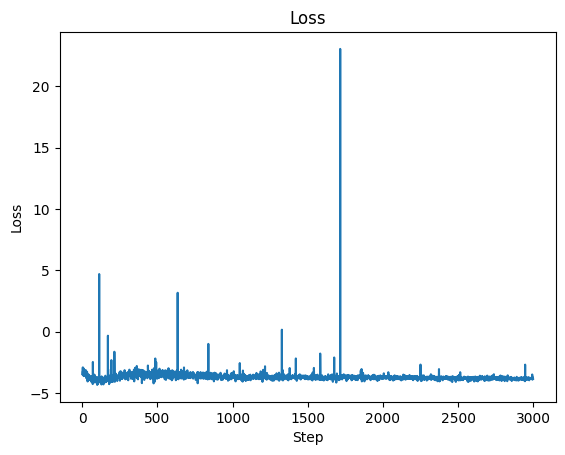

In [57]:
plt.plot(loss_arr_dist)
plt.title('Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [58]:
# Inference

# Sample points from warped space
with torch.no_grad():
  z_0 = proposal.sample(1000).squeeze()

# Apply HMC to points from warped space
chains = HMC(
            z_0,
            target,
            N_SAMPLES,
            BURN_IN,
            step_size = 0.3,
            num_leapfrog_steps = 7,
            verbose = False,
          )

# Apply RealNVP to chains and get final samples
with torch.no_grad():
  chains = chains.float()
  chains_no_grad = chains.detach().float()
  z = nfm.forward(chains_no_grad)

Sample: 100%|██████████| 1/1 [00:00, 72.57it/s, step size=2.40e+00, acc. prob=0.000]


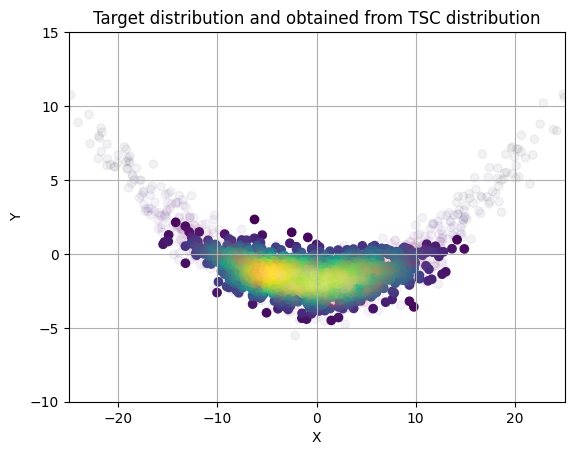

In [71]:
numpy_array = z.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from TSC distribution')
ax.grid(True)
visualize_dist_(numpy_array, ax)
target.visualize_dist_nf(ax=ax, s=1000, nf = None, alpha=0.05)
ax.set_xlim(-25, 25)  # Adjust the limits as needed
ax.set_ylim(-10, 15)  # Adjust the limits as needed
plt.show()

In [72]:
# Calculate metrics

true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(), # True samples [num of samples, dim]
                      z.transpose(0,1).numpy(), # Generated samples [num_of_samples, num of chains, dim]
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.234, Std: 0.005. 
ESS: 0.505 
EMD: 31.664


In [73]:
metrics

{'ess': 0.5045606285261102,
 'tv_mean': Array(0.23419142, dtype=float32),
 'tv_conf_sigma': Array(0.00485109, dtype=float32),
 'emd': 31.66366809029735}

### dim=10

In [17]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 10 # Dimension

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1
BURN_IN = 0
device="cpu"

In [18]:
# Define target and proposal

target = Banana(dim=dim, b=0.02)
proposal = nf.distributions.base.GaussianMixture(n_modes = 2, dim = latent_size, trainable=True)

In [19]:
# Define layers of RealNVP

K = 4
b = torch.Tensor([1] * (latent_size // 2) + [0] * (latent_size // 2))
flows = []
for g in range(K):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    if g % 2 == 0:
      flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
      flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
nfm = nf.NormalizingFlow(proposal, flows, target)

In [20]:
# Define optimizer and scheduler

optimizer_t = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_t = StepLR(optimizer_t, 1, gamma=1e-4)

In [21]:
# Training

torch.manual_seed(296)
n_iter = 500

# magic params for loss
num_samples = 2 * 10
anneal_iter = 500

loss_arr_dist = []

for i in tqdm(range(n_iter)):

    optimizer_t.zero_grad()

    # Sample a point from warped space
    if i % 50 == 0:
      z_0 = proposal.sample(N_CHAINS).squeeze()

    # Apply HMC to this point in warped space
    chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size = 0.1,
                  num_leapfrog_steps = 10,
                  verbose = False,
                )
    chains = chains.float()
    chains_no_grad = chains.detach().float()

    # Apply RealNVP to the chain and get the final sample
    z = nfm.forward(chains_no_grad)

    if (i % 99 == 0):
      print("Scale:", proposal.log_scale)
      print("Loc:", proposal.loc)

    # Calculate loss
    loss_t = nfm.reverse_kld(num_samples, beta=np.min([1., 0.01 + i / anneal_iter]))
    loss_t.backward(retain_graph=True)

    # Return back to warped space
    z_0 = nfm.inverse(z).squeeze()
    optimizer_t.step()

    loss_arr_dist.append(loss_t.detach().item())

  0%|          | 0/500 [00:00<?, ?it/s]

Sample: 100%|██████████| 1/1 [00:00, 21.44it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.0061, -0.7176, -0.4667, -1.1305, -0.9437,  0.8326,  1.0367,
          -0.3068,  1.2987,  2.0016],
         [ 1.3439, -0.1179, -0.4401,  0.8396,  0.5482,  1.1205,  1.3954,
           0.8220, -1.6012, -1.3466]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 79.16it/s, step size=1.60e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[0.0397, 0.0233, 0.0371, 0.0196, 0.0143, 0.0212, 0.0708, 0.0154,
          0.0306, 0.0123],
         [0.0288, 0.0416, 0.0455, 0.0223, 0.0492, 0.0491, 0.0564, 0.0427,
          0.0315, 0.0606]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.0069, -0.7328, -0.4808, -1.1441, -0.9566,  0.8081,  1.0486,
          -0.3338,  1.3194,  2.0047],
         [ 1.3635, -0.1239, -0.4602,  0.8257,  0.5641,  1.0917,  1.4214,
           0.7939, -1.6220, -1.3513]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 68.82it/s, step size=1.60e+00, acc. prob=0.007]


Scale: Parameter containing:
tensor([[[0.0306, 0.0269, 0.0645, 0.0189, 0.0133, 0.0246, 0.0974, 0.0129,
          0.0354, 0.0125],
         [0.0384, 0.0502, 0.0360, 0.0273, 0.0512, 0.0624, 0.0917, 0.0490,
          0.0365, 0.0711]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.0066, -0.7429, -0.4875, -1.1466, -0.9536,  0.8026,  1.0431,
          -0.3296,  1.3159,  1.9993],
         [ 1.3675, -0.1358, -0.4573,  0.8241,  0.5645,  1.0718,  1.4111,
           0.7731, -1.6164, -1.3400]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 82.65it/s, step size=8.00e-01, acc. prob=0.802]


Scale: Parameter containing:
tensor([[[0.0328, 0.0179, 0.0654, 0.0186, 0.0142, 0.0228, 0.1079, 0.0116,
          0.0434, 0.0145],
         [0.0478, 0.0581, 0.0451, 0.0245, 0.0548, 0.0542, 0.1170, 0.0536,
          0.0393, 0.0795]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.0081, -0.7552, -0.4826, -1.1497, -0.9543,  0.8064,  1.0296,
          -0.3262,  1.3166,  1.9963],
         [ 1.3596, -0.1323, -0.4583,  0.8335,  0.5674,  1.0714,  1.4181,
           0.7600, -1.6149, -1.3271]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 56.14it/s, step size=1.60e+00, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[0.0325, 0.0083, 0.0745, 0.0170, 0.0158, 0.0217, 0.1199, 0.0111,
          0.0486, 0.0166],
         [0.0488, 0.0568, 0.0517, 0.0148, 0.0528, 0.0483, 0.1356, 0.0444,
          0.0367, 0.0822]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.0081, -0.7682, -0.4847, -1.1537, -0.9543,  0.8112,  1.0247,
          -0.3247,  1.3164,  1.9940],
         [ 1.3650, -0.1441, -0.4549,  0.8433,  0.5780,  1.0663,  1.4092,
           0.7428, -1.6116, -1.3072]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 48.01it/s, step size=1.60e+00, acc. prob=0.581]


Scale: Parameter containing:
tensor([[[ 0.0295, -0.0118,  0.0815,  0.0156,  0.0167,  0.0189,  0.1121,
           0.0097,  0.0517,  0.0163],
         [ 0.0532,  0.0594,  0.0519,  0.0117,  0.0505,  0.0261,  0.1519,
           0.0412,  0.0359,  0.0815]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.0133, -0.7675, -0.4820, -1.1566, -0.9537,  0.8121,  1.0317,
          -0.3220,  1.3125,  1.9897],
         [ 1.3530, -0.1568, -0.4600,  0.8474,  0.5847,  1.0525,  1.3984,
           0.7111, -1.6069, -1.2827]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 72.01it/s, step size=1.60e+00, acc. prob=0.000]


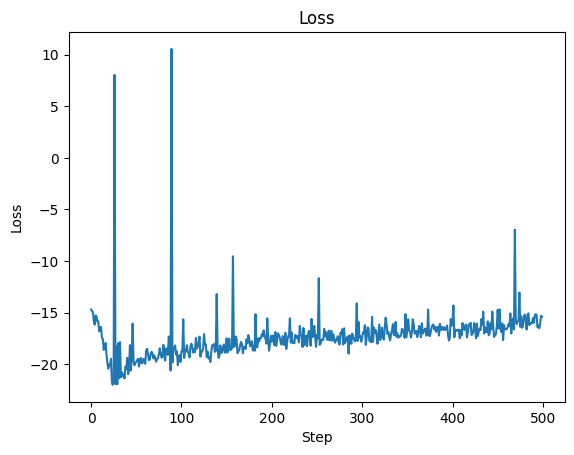

In [22]:
plt.plot(loss_arr_dist)
plt.title('Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [25]:
# Inference

# Sample points from warped space
with torch.no_grad():
  z_0 = proposal.sample(1000).squeeze()

# Apply HMC to points from warped space
chains = HMC(
            z_0,
            target,
            N_SAMPLES,
            BURN_IN,
            step_size = 0.3,
            num_leapfrog_steps = 7,
            verbose = False,
          )

# Apply RealNVP to chains and get final samples
with torch.no_grad():
  chains = chains.float()
  chains_no_grad = chains.detach().float()
  z = nfm.forward(chains_no_grad)

Sample: 100%|██████████| 1/1 [00:00, 26.04it/s, step size=2.40e+00, acc. prob=0.000]


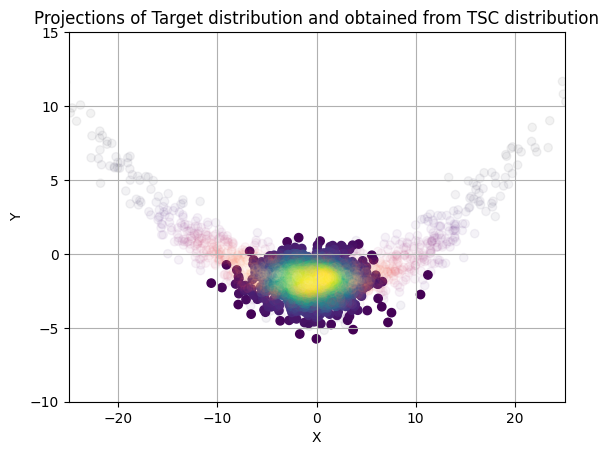

In [26]:
numpy_array = z.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Projections of Target distribution and obtained from TSC distribution')
ax.grid(True)
visualize_dist_(numpy_array, ax)
target.visualize_dist_nf(ax=ax, s=1000, nf = None, alpha=0.05)
ax.set_xlim(-25, 25)  # Adjust the limits as needed
ax.set_ylim(-10, 15)  # Adjust the limits as needed
plt.show()

In [27]:
# Calculate metrics

true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(), # True samples [num of samples, dim]
                      z.transpose(0,1).numpy(), # Generated samples [num_of_samples, num of chains, dim]
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.487, Std: 0.006. 
ESS: 0.462 
EMD: 339.879


In [28]:
metrics

{'ess': 0.4619992456649423,
 'tv_mean': Array(0.4867395, dtype=float32),
 'tv_conf_sigma': Array(0.00562567, dtype=float32),
 'emd': 339.87885653915043}

### dim=50

In [45]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 50 # Dimension

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1
BURN_IN = 0
device="cpu"

In [46]:
# Define target and proposal

target = Banana(dim=dim, b=0.02)
proposal = nf.distributions.base.GaussianMixture(n_modes = 2, dim = latent_size, trainable=True)

In [47]:
# Define layers of RealNVP

K = 3
b = torch.Tensor([1] * (latent_size // 2) + [0] * (latent_size // 2))
flows = []
for g in range(K):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    if g % 2 == 0:
      flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
      flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
nfm = nf.NormalizingFlow(proposal, flows, target)

In [48]:
# Define optimizer and scheduler

optimizer_t = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_t = StepLR(optimizer_t, 1, gamma=1e-4)

In [49]:
# Training

torch.manual_seed(296)
n_iter = 3000

# magic params for loss
num_samples = 2 * 10
anneal_iter = 500

loss_arr_dist = []

for i in tqdm(range(n_iter)):

    optimizer_t.zero_grad()

    # Sample a point from warped space
    if i % 50 == 0:
      z_0 = proposal.sample(N_CHAINS).squeeze()

    # Apply HMC to this point in warped space
    chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size = 0.1,
                  num_leapfrog_steps = 10,
                  verbose = False,
                )
    chains = chains.float()
    chains_no_grad = chains.detach().float()

    # Apply RealNVP to the chain and get the final sample
    z = nfm.forward(chains_no_grad)

    if (i % 99 == 0):
      print("Scale:", proposal.log_scale)
      print("Loc:", proposal.loc)

    # Calculate loss
    loss_t = nfm.reverse_kld(num_samples, beta=np.min([1., 0.01 + i / anneal_iter]))
    loss_t.backward(retain_graph=True)

    # Return back to warped space
    z_0 = nfm.inverse(z).squeeze()
    optimizer_t.step()

    loss_arr_dist.append(loss_t.detach().item())

  0%|          | 0/3000 [00:00<?, ?it/s]

Sample: 100%|██████████| 1/1 [00:00, 43.80it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.1449, -0.1499, -0.3255,  1.3071,  0.5351,  1.1710,  1.3731,
           0.5903, -0.1672,  1.2578, -0.6471,  1.3371, -0.9032,  0.3440,
          -0.4992, -0.1424,  1.4251, -0.4265,  0.3437, -1.2100, -0.7962,
           0.1287, -1.0406,  0.8630,  0.6779, -1.1305,  0.4422, -0.2541,
          -1.2677, -2.6071, -0.4088,  0.3524,  0.9937, -0.5263, -1.0448,
           0.7819,  1.1574,  0.5501, -1.9385,  0.6817, -0.8040,  2.1158,
          -0.3225,  0.

Sample: 100%|██████████| 1/1 [00:00, 63.62it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0007,  0.0048,  0.0306,  0.0064,  0.0044,  0.0052,  0.0063,
           0.0269, -0.0008,  0.0044,  0.0002,  0.0070,  0.0125,  0.0097,
           0.0198,  0.0036,  0.0068,  0.0147,  0.0228,  0.0091,  0.0137,
           0.0114,  0.0012,  0.0122,  0.0096,  0.0216,  0.0267,  0.0017,
           0.0107,  0.0164, -0.0013,  0.0049,  0.0255, -0.0010,  0.0259,
           0.0023,  0.0079,  0.0003,  0.0265,  0.0127,  0.0026,  0.0153,
          -0.0015,  0.0171,  0.0227,  0.0210, -0.0019,  0.0166,  0.0134,
           0.0233],
         [ 0.0060,  0.0137,  0.0031,  0.0076,  0.0243,  0.0076,  0.0065,
           0.0182,  0.0063,  0.0167,  0.0087,  0.0053,  0.0305,  0.0131,
           0.0175,  0.0036,  0.0049,  0.0052,  0.0099,  0.0084,  0.0320,
          -0.0005,  0.0043,  0.0455,  0.0332,  0.0044,  0.0138,  0.0037,
           0.0029,  0.0099,  0.0281,  0.0046,  0.0052,  0.0045,  0.0062,
           0.0042,  0.0185,  0.0056,  0.0257,  0.0226,  0.0202,  0.0086,
  

Sample: 100%|██████████| 1/1 [00:00, 56.14it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0008,  0.0082,  0.0325,  0.0141,  0.0096,  0.0068,  0.0248,
           0.0272, -0.0005,  0.0056,  0.0036,  0.0124,  0.0192,  0.0096,
           0.0198,  0.0023,  0.0213,  0.0082,  0.0220,  0.0122,  0.0197,
           0.0108,  0.0022,  0.0118,  0.0142,  0.0215,  0.0249,  0.0018,
           0.0172,  0.0176,  0.0002,  0.0048,  0.0257, -0.0002,  0.0292,
           0.0019,  0.0140,  0.0008,  0.0226,  0.0211,  0.0031,  0.0183,
          -0.0015,  0.0152,  0.0340,  0.0236, -0.0004,  0.0172,  0.0146,
           0.0235],
         [ 0.0078,  0.0276,  0.0039,  0.0026,  0.0264,  0.0100,  0.0104,
           0.0129,  0.0072,  0.0179,  0.0124,  0.0078,  0.0236,  0.0103,
           0.0082,  0.0006,  0.0074,  0.0032,  0.0101,  0.0114,  0.0309,
          -0.0033, -0.0019,  0.0499,  0.0259,  0.0063,  0.0160,  0.0031,
           0.0056,  0.0141,  0.0219,  0.0013, -0.0040,  0.0020,  0.0071,
           0.0141,  0.0195,  0.0083,  0.0282,  0.0220,  0.0129,  0.0235,
  

Sample: 100%|██████████| 1/1 [00:00, 66.23it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 2.7169e-03,  6.7742e-03,  3.4304e-02,  1.7450e-02,  1.2468e-02,
           7.1443e-03,  3.1052e-02,  2.6180e-02, -7.5304e-05,  4.3041e-03,
           6.8869e-03,  1.4402e-02,  2.3025e-02,  9.5666e-03,  1.9970e-02,
           5.0163e-04,  3.3358e-02,  1.5015e-03,  2.4639e-02,  1.2880e-02,
           2.4822e-02,  1.0607e-02,  6.0022e-04,  2.4683e-03,  2.0264e-02,
           2.1105e-02,  2.6982e-02,  2.5395e-03,  2.5874e-02,  1.6582e-02,
           9.8306e-04,  4.6723e-03,  2.7398e-02,  1.7762e-04,  2.9573e-02,
           5.3187e-04,  1.9080e-02, -8.3612e-04,  3.3902e-02,  2.2344e-02,
           3.5443e-03,  1.1457e-02, -1.2388e-03,  2.9902e-03,  3.6202e-02,
           2.5639e-02,  5.5242e-04,  1.2724e-02,  1.3576e-02,  2.4329e-02],
         [ 1.0793e-02,  2.9782e-02,  8.1280e-03, -1.1252e-03,  2.7308e-02,
           9.6648e-03,  7.4201e-03,  8.0066e-03,  1.0355e-02,  2.0026e-02,
           1.1368e-02,  8.2819e-03,  2.3284e-02,  1.3948e-02,  8.9737e

Sample: 100%|██████████| 1/1 [00:00, 61.62it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0097,  0.0073,  0.0172,  0.0252,  0.0051,  0.0071,  0.0168,
           0.0146,  0.0006, -0.0035, -0.0051,  0.0024,  0.0171, -0.0053,
           0.0197,  0.0082,  0.0309,  0.0004,  0.0193, -0.0058,  0.0357,
           0.0039,  0.0136, -0.0094,  0.0113,  0.0165,  0.0161,  0.0180,
           0.0182, -0.0016,  0.0072,  0.0007,  0.0118, -0.0089,  0.0443,
          -0.0043,  0.0097, -0.0194,  0.0296,  0.0104,  0.0006, -0.0010,
          -0.0014, -0.0270,  0.0216,  0.0127,  0.0009, -0.0026,  0.0261,
           0.0076],
         [ 0.0139,  0.0286,  0.0113,  0.0012,  0.0229,  0.0034,  0.0124,
           0.0085,  0.0135,  0.0223,  0.0143,  0.0090,  0.0223,  0.0070,
           0.0157, -0.0026,  0.0109, -0.0047,  0.0039,  0.0107,  0.0419,
          -0.0084, -0.0005,  0.0403,  0.0281,  0.0076,  0.0162, -0.0037,
           0.0044,  0.0215,  0.0298,  0.0024, -0.0029,  0.0032,  0.0148,
           0.0181,  0.0135,  0.0160,  0.0247,  0.0072,  0.0138,  0.0351,
  

Sample: 100%|██████████| 1/1 [00:00, 43.51it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 1.2007e-02,  8.8487e-03,  1.7698e-02,  2.7874e-02,  1.2559e-02,
           8.6895e-03,  1.6047e-02,  1.4360e-02,  1.6818e-03, -3.9502e-03,
          -3.8883e-03,  3.9174e-03,  1.9861e-02, -5.9820e-03,  2.0037e-02,
           8.2521e-03,  4.3784e-02,  4.6972e-04,  2.6876e-02, -5.3869e-03,
           4.5544e-02,  3.6811e-03,  2.0011e-02, -6.7325e-03,  1.0703e-02,
           1.5715e-02,  1.6638e-02,  1.9957e-02,  1.7926e-02, -2.0660e-03,
           1.0136e-02,  9.5898e-04,  1.1469e-02, -1.1774e-02,  5.3297e-02,
          -3.4442e-03,  1.4339e-02, -1.9848e-02,  3.0779e-02,  9.8124e-03,
           1.3646e-03,  1.5981e-03, -1.1776e-03, -2.7829e-02,  2.2581e-02,
           1.3299e-02,  4.6090e-03, -3.1885e-03,  4.0251e-02,  6.5121e-03],
         [ 1.3341e-02,  2.7295e-02,  1.4859e-02,  1.2676e-03,  2.7348e-02,
           8.0230e-05,  1.8479e-02,  9.5876e-03,  1.4664e-02,  2.2782e-02,
           1.8920e-02,  9.2234e-03,  2.2206e-02,  2.7949e-03,  1.9625e

Sample: 100%|██████████| 1/1 [00:00, 47.04it/s, step size=1.60e+00, acc. prob=0.006]


Scale: Parameter containing:
tensor([[[ 0.0117,  0.0068,  0.0189,  0.0322,  0.0157,  0.0091,  0.0164,
           0.0146,  0.0018, -0.0046, -0.0025,  0.0026,  0.0258, -0.0060,
           0.0202,  0.0076,  0.0511,  0.0009,  0.0238, -0.0049,  0.0450,
           0.0029,  0.0243, -0.0049,  0.0111,  0.0145,  0.0175,  0.0196,
           0.0185, -0.0017,  0.0101,  0.0009,  0.0087, -0.0161,  0.0548,
          -0.0029,  0.0158, -0.0194,  0.0319,  0.0105,  0.0010,  0.0022,
          -0.0010, -0.0276,  0.0220,  0.0172,  0.0079, -0.0031,  0.0362,
           0.0064],
         [ 0.0162,  0.0266,  0.0193,  0.0031,  0.0397, -0.0002,  0.0252,
           0.0084,  0.0166,  0.0239,  0.0245,  0.0111,  0.0248,  0.0026,
           0.0252, -0.0029,  0.0174, -0.0107,  0.0019,  0.0086,  0.0528,
          -0.0067,  0.0053,  0.0346,  0.0319,  0.0104,  0.0217, -0.0020,
           0.0143,  0.0262,  0.0283,  0.0037,  0.0017,  0.0060,  0.0109,
           0.0234,  0.0127,  0.0224,  0.0299,  0.0069,  0.0148,  0.0445,
  

Sample: 100%|██████████| 1/1 [00:00, 59.19it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0126,  0.0074,  0.0200,  0.0351,  0.0194,  0.0097,  0.0167,
           0.0149,  0.0023, -0.0051, -0.0028,  0.0044,  0.0315, -0.0059,
           0.0203,  0.0079,  0.0492,  0.0019,  0.0264, -0.0045,  0.0527,
           0.0026,  0.0293, -0.0035,  0.0110,  0.0129,  0.0180,  0.0198,
           0.0189, -0.0014,  0.0116,  0.0009,  0.0091, -0.0171,  0.0580,
          -0.0020,  0.0145, -0.0188,  0.0333,  0.0112,  0.0018,  0.0028,
          -0.0008, -0.0276,  0.0218,  0.0186,  0.0091, -0.0032,  0.0378,
           0.0062],
         [ 0.0186,  0.0253,  0.0190,  0.0046,  0.0383, -0.0009,  0.0276,
           0.0083,  0.0158,  0.0234,  0.0290,  0.0120,  0.0262,  0.0026,
           0.0258, -0.0041,  0.0193, -0.0125,  0.0036,  0.0077,  0.0552,
          -0.0086,  0.0076,  0.0382,  0.0319,  0.0095,  0.0232,  0.0011,
           0.0149,  0.0251,  0.0299,  0.0041,  0.0006,  0.0041,  0.0076,
           0.0247,  0.0136,  0.0224,  0.0309,  0.0052,  0.0149,  0.0495,
  

Sample: 100%|██████████| 1/1 [00:00, 44.19it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0134,  0.0078,  0.0206,  0.0358,  0.0264,  0.0102,  0.0168,
           0.0149,  0.0026, -0.0051, -0.0014,  0.0055,  0.0340, -0.0059,
           0.0205,  0.0087,  0.0552,  0.0015,  0.0242, -0.0040,  0.0528,
           0.0024,  0.0312, -0.0035,  0.0110,  0.0111,  0.0188,  0.0196,
           0.0190, -0.0011,  0.0130,  0.0010,  0.0104, -0.0216,  0.0600,
          -0.0012,  0.0195, -0.0182,  0.0338,  0.0113,  0.0016,  0.0034,
          -0.0010, -0.0273,  0.0209,  0.0221,  0.0092, -0.0035,  0.0469,
           0.0061],
         [ 0.0194,  0.0261,  0.0213,  0.0050,  0.0430, -0.0010,  0.0270,
           0.0096,  0.0184,  0.0247,  0.0362,  0.0147,  0.0290,  0.0019,
           0.0258, -0.0043,  0.0216, -0.0102,  0.0055,  0.0055,  0.0575,
          -0.0075,  0.0092,  0.0396,  0.0339,  0.0118,  0.0251,  0.0009,
           0.0185,  0.0219,  0.0252,  0.0047,  0.0015,  0.0044,  0.0129,
           0.0282,  0.0144,  0.0244,  0.0331,  0.0076,  0.0156,  0.0589,
  

Sample: 100%|██████████| 1/1 [00:00, 40.88it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0143,  0.0074,  0.0209,  0.0352,  0.0268,  0.0108,  0.0171,
           0.0148,  0.0031, -0.0061, -0.0003,  0.0023,  0.0323, -0.0059,
           0.0200,  0.0083,  0.0532,  0.0008,  0.0257, -0.0036,  0.0600,
           0.0021,  0.0350, -0.0032,  0.0114,  0.0099,  0.0203,  0.0198,
           0.0190, -0.0012,  0.0117,  0.0009,  0.0108, -0.0232,  0.0620,
          -0.0013,  0.0174, -0.0182,  0.0347,  0.0115,  0.0026, -0.0023,
          -0.0011, -0.0272,  0.0232,  0.0223,  0.0090, -0.0034,  0.0509,
           0.0061],
         [ 0.0203,  0.0283,  0.0273,  0.0066,  0.0530, -0.0004,  0.0321,
           0.0175,  0.0162,  0.0222,  0.0373,  0.0171,  0.0325,  0.0011,
           0.0343, -0.0054,  0.0252, -0.0103,  0.0068,  0.0059,  0.0586,
          -0.0053,  0.0097,  0.0412,  0.0348,  0.0148,  0.0235,  0.0018,
           0.0224,  0.0213,  0.0245,  0.0049,  0.0037,  0.0062,  0.0147,
           0.0267,  0.0148,  0.0268,  0.0354,  0.0069,  0.0152,  0.0651,
  

Sample: 100%|██████████| 1/1 [00:00, 51.75it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0160,  0.0104,  0.0218,  0.0330,  0.0301,  0.0111,  0.0173,
           0.0147,  0.0033, -0.0080,  0.0016,  0.0046,  0.0422, -0.0059,
           0.0205,  0.0086,  0.0630,  0.0013,  0.0286, -0.0043,  0.0674,
           0.0026,  0.0391, -0.0023,  0.0118,  0.0094,  0.0195,  0.0202,
           0.0192, -0.0014,  0.0137,  0.0010,  0.0126, -0.0273,  0.0747,
          -0.0010,  0.0201, -0.0179,  0.0353,  0.0117,  0.0039, -0.0042,
          -0.0010, -0.0272,  0.0241,  0.0242,  0.0101, -0.0036,  0.0504,
           0.0062],
         [ 0.0183,  0.0317,  0.0318,  0.0044,  0.0541,  0.0003,  0.0387,
           0.0156,  0.0205,  0.0136,  0.0305,  0.0197,  0.0339,  0.0007,
           0.0416, -0.0045,  0.0284, -0.0088,  0.0082,  0.0031,  0.0600,
          -0.0077,  0.0118,  0.0417,  0.0353,  0.0146,  0.0254,  0.0016,
           0.0263,  0.0201,  0.0302, -0.0008,  0.0031,  0.0051, -0.0020,
           0.0080,  0.0180,  0.0362,  0.0393,  0.0050,  0.0151,  0.0695,
  

Sample: 100%|██████████| 1/1 [00:00, 45.97it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 1.6038e-02,  5.9589e-03,  2.2567e-02,  2.6745e-02,  3.1034e-02,
           1.1080e-02,  1.7596e-02,  1.4538e-02,  3.2424e-03, -1.0696e-02,
           2.8901e-03,  6.5453e-03,  4.8877e-02, -5.9293e-03,  2.0586e-02,
           8.6431e-03,  7.3476e-02,  1.8820e-03,  3.0693e-02, -4.1984e-03,
           7.0390e-02,  2.5034e-03,  4.2402e-02, -1.2872e-03,  1.2258e-02,
           8.0213e-03,  2.0908e-02,  2.0371e-02,  1.8974e-02, -1.3803e-03,
           1.4753e-02,  1.1155e-03,  1.2591e-02, -2.5811e-02,  7.2945e-02,
          -2.7840e-04,  2.3076e-02, -1.7352e-02,  3.5732e-02,  1.1981e-02,
           4.2746e-03, -1.2108e-02, -9.1202e-04, -2.7164e-02,  2.2857e-02,
           2.6898e-02,  1.0350e-02, -4.3930e-03,  5.9661e-02,  6.2008e-03],
         [ 2.1586e-02,  2.8677e-02,  3.5952e-02,  5.0366e-03,  5.4341e-02,
          -1.6497e-04,  3.8646e-02,  1.6250e-02,  2.3978e-02,  1.1905e-02,
           3.4259e-02,  2.1324e-02,  3.6773e-02, -1.4789e-03,  4.4094e

Sample: 100%|██████████| 1/1 [00:00, 59.62it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0172,  0.0062,  0.0230,  0.0261,  0.0363,  0.0121,  0.0179,
           0.0145,  0.0036, -0.0129,  0.0039,  0.0044,  0.0537, -0.0060,
           0.0208,  0.0107,  0.0794,  0.0029,  0.0305, -0.0038,  0.0763,
           0.0023,  0.0471, -0.0016,  0.0123,  0.0074,  0.0212,  0.0203,
           0.0195, -0.0016,  0.0148,  0.0015,  0.0134, -0.0274,  0.0650,
          -0.0006,  0.0253, -0.0171,  0.0356,  0.0122,  0.0048, -0.0124,
          -0.0009, -0.0272,  0.0256,  0.0301,  0.0127, -0.0050,  0.0632,
           0.0063],
         [ 0.0215,  0.0271,  0.0377,  0.0082,  0.0573,  0.0001,  0.0403,
           0.0168,  0.0261,  0.0093,  0.0353,  0.0237,  0.0382, -0.0018,
           0.0407, -0.0042,  0.0346, -0.0095,  0.0082,  0.0054,  0.0674,
          -0.0072,  0.0127,  0.0432,  0.0404,  0.0144,  0.0275, -0.0024,
           0.0345,  0.0265,  0.0306, -0.0002,  0.0040,  0.0051,  0.0077,
           0.0097,  0.0176,  0.0386,  0.0445,  0.0017,  0.0147,  0.0790,
  

Sample: 100%|██████████| 1/1 [00:00, 41.32it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0172,  0.0078,  0.0238,  0.0273,  0.0437,  0.0123,  0.0182,
           0.0140,  0.0034, -0.0121,  0.0048,  0.0051,  0.0586, -0.0060,
           0.0209,  0.0119,  0.0810,  0.0014,  0.0298, -0.0045,  0.0818,
           0.0022,  0.0514, -0.0006,  0.0126,  0.0075,  0.0227,  0.0207,
           0.0196, -0.0022,  0.0153,  0.0014,  0.0133, -0.0270,  0.0667,
          -0.0010,  0.0264, -0.0166,  0.0369,  0.0120,  0.0050, -0.0180,
          -0.0006, -0.0271,  0.0267,  0.0332,  0.0136, -0.0056,  0.0634,
           0.0063],
         [ 0.0245,  0.0184,  0.0421,  0.0081,  0.0583,  0.0014,  0.0407,
           0.0164,  0.0286,  0.0073,  0.0378,  0.0265,  0.0410, -0.0013,
           0.0453, -0.0045,  0.0383, -0.0101,  0.0091,  0.0038,  0.0656,
          -0.0047,  0.0148,  0.0422,  0.0426,  0.0143,  0.0260, -0.0041,
           0.0337,  0.0336,  0.0321,  0.0003,  0.0044,  0.0069,  0.0107,
           0.0110,  0.0187,  0.0382,  0.0476,  0.0038,  0.0139,  0.0836,
  

Sample: 100%|██████████| 1/1 [00:00, 55.59it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 1.7583e-02,  9.2187e-03,  2.4552e-02,  2.6036e-02,  4.3867e-02,
           1.2470e-02,  1.8389e-02,  1.4601e-02,  3.5198e-03, -1.5705e-02,
           6.0297e-03,  6.6795e-03,  6.0850e-02, -6.0207e-03,  2.1118e-02,
           1.1305e-02,  9.7574e-02,  2.8498e-03,  3.3525e-02, -5.2148e-03,
           8.4485e-02,  2.4089e-03,  5.4857e-02, -8.6967e-04,  1.3106e-02,
           6.3268e-03,  2.3825e-02,  2.0480e-02,  1.9612e-02, -2.1538e-03,
           1.7133e-02,  9.8860e-04,  1.4579e-02, -2.5557e-02,  7.0961e-02,
           2.8181e-05,  2.9806e-02, -1.6401e-02,  3.8428e-02,  1.2934e-02,
           6.1754e-03, -1.8943e-02, -6.8819e-04, -2.7902e-02,  2.7862e-02,
           3.5256e-02,  1.4220e-02, -5.9717e-03,  5.8687e-02,  6.2797e-03],
         [ 2.4833e-02,  1.5045e-02,  4.3596e-02,  1.2007e-02,  6.3799e-02,
           1.7665e-03,  4.2545e-02,  1.4783e-02,  2.9995e-02,  1.6288e-03,
           3.7955e-02,  2.9831e-02,  4.2671e-02, -4.1393e-04,  4.5072e

Sample: 100%|██████████| 1/1 [00:00, 38.63it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0176,  0.0086,  0.0250,  0.0262,  0.0478,  0.0126,  0.0186,
           0.0145,  0.0044, -0.0187,  0.0066,  0.0097,  0.0626, -0.0061,
           0.0213,  0.0118,  0.1074,  0.0027,  0.0336, -0.0038,  0.0873,
           0.0022,  0.0581, -0.0008,  0.0133,  0.0060,  0.0241,  0.0205,
           0.0203, -0.0025,  0.0164,  0.0010,  0.0153, -0.0275,  0.0725,
          -0.0007,  0.0322, -0.0159,  0.0409,  0.0138,  0.0069, -0.0245,
          -0.0007, -0.0278,  0.0269,  0.0343,  0.0151, -0.0060,  0.0600,
           0.0062],
         [ 0.0271,  0.0150,  0.0444,  0.0109,  0.0703,  0.0011,  0.0452,
           0.0128,  0.0293, -0.0004,  0.0386,  0.0305,  0.0415, -0.0024,
           0.0439, -0.0025,  0.0431, -0.0100,  0.0106,  0.0114,  0.0689,
          -0.0061,  0.0190,  0.0420,  0.0450,  0.0146,  0.0301, -0.0019,
           0.0401,  0.0402,  0.0377,  0.0008,  0.0050,  0.0074,  0.0138,
           0.0127,  0.0180,  0.0374,  0.0492, -0.0038,  0.0134,  0.0901,
  

Sample: 100%|██████████| 1/1 [00:00, 56.71it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0182,  0.0115,  0.0257,  0.0272,  0.0502,  0.0136,  0.0188,
           0.0137,  0.0047, -0.0198,  0.0074,  0.0096,  0.0680, -0.0060,
           0.0214,  0.0112,  0.1146,  0.0007,  0.0348, -0.0042,  0.0947,
           0.0018,  0.0603,  0.0007,  0.0137,  0.0051,  0.0245,  0.0200,
           0.0205, -0.0026,  0.0189,  0.0014,  0.0168, -0.0280,  0.0741,
          -0.0008,  0.0325, -0.0155,  0.0428,  0.0139,  0.0070, -0.0278,
          -0.0005, -0.0279,  0.0271,  0.0359,  0.0163, -0.0066,  0.0633,
           0.0062],
         [ 0.0299,  0.0099,  0.0452,  0.0135,  0.0711,  0.0019,  0.0452,
           0.0124,  0.0326, -0.0037,  0.0409,  0.0303,  0.0453, -0.0043,
           0.0454, -0.0016,  0.0478, -0.0068,  0.0122,  0.0101,  0.0691,
          -0.0031,  0.0188,  0.0375,  0.0466,  0.0152,  0.0296, -0.0015,
           0.0412,  0.0451,  0.0347,  0.0003,  0.0040,  0.0090,  0.0158,
           0.0154,  0.0194,  0.0381,  0.0481,  0.0011,  0.0135,  0.0936,
  

Sample: 100%|██████████| 1/1 [00:00, 35.31it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0196,  0.0101,  0.0264,  0.0235,  0.0511,  0.0140,  0.0191,
           0.0135,  0.0052, -0.0205,  0.0082,  0.0092,  0.0718, -0.0059,
           0.0215,  0.0109,  0.1305,  0.0003,  0.0301, -0.0032,  0.0876,
           0.0021,  0.0650,  0.0016,  0.0140,  0.0049,  0.0255,  0.0204,
           0.0208, -0.0025,  0.0181,  0.0014,  0.0166, -0.0289,  0.0714,
          -0.0006,  0.0351, -0.0160,  0.0423,  0.0138,  0.0074, -0.0276,
          -0.0004, -0.0277,  0.0279,  0.0353,  0.0164, -0.0066,  0.0657,
           0.0062],
         [ 0.0293,  0.0061,  0.0475,  0.0171,  0.0730,  0.0008,  0.0486,
           0.0113,  0.0355, -0.0066,  0.0390,  0.0313,  0.0479, -0.0057,
           0.0495, -0.0008,  0.0498, -0.0071,  0.0127,  0.0124,  0.0798,
          -0.0040,  0.0203,  0.0382,  0.0502,  0.0162,  0.0280, -0.0021,
           0.0459,  0.0481,  0.0373,  0.0008,  0.0056,  0.0108,  0.0179,
           0.0157,  0.0194,  0.0391,  0.0584, -0.0044,  0.0141,  0.0995,
  

Sample: 100%|██████████| 1/1 [00:00, 55.30it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0187,  0.0108,  0.0273,  0.0199,  0.0553,  0.0127,  0.0195,
           0.0136,  0.0057, -0.0220,  0.0097,  0.0058,  0.0722, -0.0060,
           0.0216,  0.0111,  0.1381, -0.0007,  0.0316, -0.0039,  0.0923,
           0.0020,  0.0678,  0.0018,  0.0142,  0.0040,  0.0256,  0.0200,
           0.0211, -0.0025,  0.0188,  0.0013,  0.0176, -0.0310,  0.0733,
          -0.0005,  0.0349, -0.0161,  0.0452,  0.0143,  0.0078, -0.0279,
          -0.0005, -0.0278,  0.0289,  0.0372,  0.0172, -0.0064,  0.0636,
           0.0062],
         [ 0.0328,  0.0087,  0.0479,  0.0157,  0.0771,  0.0003,  0.0462,
           0.0130,  0.0348, -0.0101,  0.0386,  0.0340,  0.0489, -0.0060,
           0.0496,  0.0007,  0.0570, -0.0049,  0.0142,  0.0138,  0.0823,
          -0.0058,  0.0186,  0.0360,  0.0523,  0.0179,  0.0337, -0.0018,
           0.0435,  0.0505,  0.0369,  0.0014,  0.0047,  0.0130,  0.0187,
           0.0171,  0.0211,  0.0405,  0.0579, -0.0062,  0.0143,  0.1017,
  

Sample: 100%|██████████| 1/1 [00:00, 41.69it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 1.9024e-02,  8.2588e-03,  2.8228e-02,  2.5542e-02,  5.4555e-02,
           1.2494e-02,  1.9748e-02,  1.3356e-02,  6.4787e-03, -2.1258e-02,
           1.0580e-02,  8.8123e-03,  7.4636e-02, -6.1621e-03,  2.1765e-02,
           1.1629e-02,  1.5686e-01, -7.4165e-04,  3.1063e-02, -2.7021e-03,
           9.4769e-02,  2.1973e-03,  6.8144e-02,  1.7497e-03,  1.4292e-02,
           4.0350e-03,  2.5311e-02,  1.9749e-02,  2.1255e-02, -3.1525e-03,
           1.7910e-02,  1.2966e-03,  1.8332e-02, -2.9094e-02,  7.2917e-02,
           1.3747e-04,  3.8009e-02, -1.5491e-02,  4.6882e-02,  1.5108e-02,
           8.6710e-03, -3.2592e-02, -3.8608e-04, -2.7832e-02,  2.9005e-02,
           4.1201e-02,  1.5601e-02, -6.6631e-03,  6.6596e-02,  6.2893e-03],
         [ 3.4933e-02,  6.9049e-03,  5.1024e-02,  1.4672e-02,  8.2669e-02,
           2.4815e-03,  4.7448e-02,  6.5674e-03,  3.4860e-02, -1.3277e-02,
           4.2940e-02,  3.6226e-02,  5.2173e-02, -6.2466e-03,  4.7541e

Sample: 100%|██████████| 1/1 [00:00, 56.38it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 1.5896e-02, -6.4067e-03,  2.8320e-02,  2.7543e-03,  5.4720e-02,
           1.1249e-03,  1.9896e-02,  9.8142e-03,  6.9243e-03, -8.7184e-03,
           1.1927e-02,  1.3933e-03,  7.8890e-02, -5.1987e-03,  2.1746e-02,
           1.0478e-02,  1.7171e-01,  3.3982e-03,  3.3205e-02, -4.6698e-03,
           9.0460e-02, -6.5358e-03,  7.1244e-02, -1.3890e-02,  1.0188e-03,
           5.5723e-03,  2.6039e-02,  1.8077e-02,  2.0964e-02, -2.8558e-03,
           2.2779e-02,  1.6389e-03,  3.9903e-03, -4.7357e-02,  7.4621e-02,
          -6.6726e-04,  2.5876e-02, -1.7484e-02,  4.6022e-02,  1.5701e-02,
           5.7791e-03, -5.6496e-02, -8.3400e-05, -2.8114e-02,  1.0230e-02,
           3.5222e-02,  1.4626e-02, -1.0656e-02,  7.8661e-02,  5.2367e-03],
         [ 3.4377e-02,  4.2166e-03,  5.4550e-02,  1.6769e-02,  8.8563e-02,
           2.3868e-03,  4.6263e-02,  8.6685e-03,  3.5848e-02, -1.6903e-02,
           4.4561e-02,  3.8019e-02,  5.2014e-02, -6.2894e-03,  5.0435e

Sample: 100%|██████████| 1/1 [00:00, 55.90it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0189, -0.0178,  0.0303, -0.0047,  0.0662, -0.0010,  0.0207,
           0.0068,  0.0088, -0.0013,  0.0138,  0.0003,  0.0949, -0.0045,
           0.0224,  0.0099,  0.2005,  0.0041,  0.0440, -0.0057,  0.0956,
          -0.0117,  0.0816, -0.0185, -0.0022,  0.0049,  0.0279,  0.0185,
           0.0215, -0.0027,  0.0266,  0.0020,  0.0014, -0.0483,  0.0817,
           0.0013,  0.0254, -0.0163,  0.0508,  0.0154,  0.0062, -0.0589,
           0.0004, -0.0276,  0.0081,  0.0379,  0.0180, -0.0110,  0.0856,
           0.0052],
         [ 0.0411,  0.0044,  0.0536,  0.0154,  0.0859,  0.0010,  0.0490,
          -0.0022,  0.0353, -0.0215,  0.0447,  0.0401,  0.0549, -0.0031,
           0.0530, -0.0004,  0.0672, -0.0014,  0.0160,  0.0057,  0.0950,
          -0.0097,  0.0244,  0.0276,  0.0612,  0.0188,  0.0342,  0.0029,
           0.0479,  0.0652,  0.0312,  0.0027,  0.0101,  0.0193,  0.0232,
           0.0218,  0.0238,  0.0432,  0.0606, -0.0142,  0.0129,  0.1212,
  

Sample: 100%|██████████| 1/1 [00:00, 41.61it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0195, -0.0134,  0.0313, -0.0090,  0.0697, -0.0008,  0.0210,
           0.0062,  0.0089, -0.0038,  0.0155, -0.0002,  0.0932, -0.0045,
           0.0227,  0.0118,  0.2125,  0.0048,  0.0461, -0.0037,  0.1068,
          -0.0115,  0.0866, -0.0195, -0.0007,  0.0022,  0.0286,  0.0193,
           0.0224, -0.0034,  0.0264,  0.0016,  0.0036, -0.0458,  0.0813,
           0.0020,  0.0289, -0.0162,  0.0519,  0.0148,  0.0063, -0.0582,
           0.0005, -0.0279,  0.0095,  0.0413,  0.0185, -0.0108,  0.0943,
           0.0054],
         [ 0.0437,  0.0052,  0.0525,  0.0161,  0.0823,  0.0026,  0.0522,
          -0.0021,  0.0383, -0.0251,  0.0456,  0.0415,  0.0577, -0.0048,
           0.0525,  0.0021,  0.0726, -0.0033,  0.0170,  0.0091,  0.0967,
          -0.0096,  0.0220,  0.0293,  0.0649,  0.0217,  0.0323,  0.0014,
           0.0485,  0.0716,  0.0414,  0.0031,  0.0103,  0.0198,  0.0240,
           0.0209,  0.0246,  0.0411,  0.0633, -0.0183,  0.0137,  0.1233,
  

Sample: 100%|██████████| 1/1 [00:00, 37.31it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0209, -0.0104,  0.0321, -0.0067,  0.0666, -0.0006,  0.0215,
           0.0057,  0.0093, -0.0033,  0.0162,  0.0032,  0.0987, -0.0042,
           0.0229,  0.0135,  0.2294,  0.0039,  0.0460, -0.0026,  0.1117,
          -0.0120,  0.0884, -0.0182,  0.0006,  0.0014,  0.0296,  0.0193,
           0.0228, -0.0038,  0.0272,  0.0013,  0.0050, -0.0447,  0.0837,
           0.0022,  0.0321, -0.0156,  0.0539,  0.0152,  0.0070, -0.0578,
           0.0004, -0.0284,  0.0130,  0.0419,  0.0192, -0.0105,  0.0918,
           0.0052],
         [ 0.0451,  0.0006,  0.0544,  0.0135,  0.0879,  0.0028,  0.0519,
           0.0026,  0.0396, -0.0271,  0.0458,  0.0417,  0.0628, -0.0052,
           0.0473,  0.0037,  0.0789, -0.0033,  0.0177,  0.0084,  0.0953,
          -0.0081,  0.0255,  0.0309,  0.0656,  0.0208,  0.0321,  0.0013,
           0.0486,  0.0725,  0.0430, -0.0011,  0.0114,  0.0207,  0.0258,
           0.0180,  0.0259,  0.0388,  0.0619, -0.0266,  0.0136,  0.1259,
  

Sample: 100%|██████████| 1/1 [00:00, 51.14it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 1.9050e-02, -1.0286e-02,  3.2990e-02, -9.1958e-03,  7.0793e-02,
          -4.5776e-06,  2.1480e-02,  5.4033e-03,  9.3528e-03, -3.3392e-03,
           1.6099e-02,  4.6420e-03,  9.9233e-02, -4.3879e-03,  2.3152e-02,
           1.2051e-02,  2.3648e-01,  4.2690e-03,  4.8227e-02, -3.8048e-03,
           1.1452e-01, -1.1861e-02,  9.2311e-02, -1.9275e-02,  1.3479e-03,
           8.7663e-04,  3.0394e-02,  1.9103e-02,  2.3504e-02, -3.7594e-03,
           2.7724e-02,  6.9772e-04,  5.4470e-03, -4.3190e-02,  9.0327e-02,
           1.8091e-03,  3.2363e-02, -1.5599e-02,  5.4393e-02,  1.4428e-02,
           7.2854e-03, -5.6311e-02,  7.3913e-04, -2.8811e-02,  1.3512e-02,
           4.2347e-02,  1.9600e-02, -1.0687e-02,  8.9416e-02,  5.4311e-03],
         [ 4.9055e-02,  1.1708e-03,  5.6095e-02,  1.4182e-02,  9.4627e-02,
           1.6969e-03,  5.5967e-02,  8.4767e-04,  4.0962e-02, -3.1509e-02,
           4.7390e-02,  4.5946e-02,  6.1397e-02, -6.4941e-03,  5.2500e

Sample: 100%|██████████| 1/1 [00:00, 43.12it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 2.0091e-02, -1.1936e-02,  3.3840e-02, -8.7429e-03,  7.3835e-02,
           4.6161e-04,  2.1899e-02,  5.6125e-03,  9.5672e-03, -6.3334e-03,
           1.6248e-02,  2.0896e-03,  9.8379e-02, -4.7685e-03,  2.3430e-02,
           1.0836e-02,  2.5055e-01,  2.9523e-03,  4.9246e-02, -2.4912e-03,
           1.1437e-01, -1.1942e-02,  9.4571e-02, -1.6506e-02,  2.0730e-03,
           9.1177e-04,  3.0639e-02,  1.8465e-02,  2.4137e-02, -4.1692e-03,
           2.7121e-02,  4.2953e-04,  6.6302e-03, -4.2204e-02,  9.1864e-02,
           1.6921e-03,  3.4227e-02, -1.5328e-02,  5.6242e-02,  1.3278e-02,
           8.3191e-03, -5.6188e-02,  2.4997e-04, -2.8816e-02,  1.3863e-02,
           4.4183e-02,  1.9514e-02, -1.0116e-02,  9.6279e-02,  5.4601e-03],
         [ 4.9455e-02, -2.5660e-03,  5.4744e-02,  1.7367e-02,  9.6714e-02,
           2.9861e-04,  5.6529e-02,  1.6765e-03,  4.2934e-02, -3.4175e-02,
           4.7982e-02,  4.8077e-02,  6.5428e-02, -4.3356e-03,  5.2031e

Sample: 100%|██████████| 1/1 [00:00, 51.04it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 1.9818e-02, -1.2652e-02,  3.4879e-02, -8.3725e-03,  7.9121e-02,
          -1.3099e-03,  2.2263e-02,  5.7293e-03,  9.6931e-03, -8.4327e-03,
           1.7425e-02,  4.8138e-03,  9.9546e-02, -4.7619e-03,  2.3499e-02,
           1.3948e-02,  2.5929e-01,  4.8713e-03,  4.8569e-02, -8.9577e-04,
           1.1437e-01, -1.1941e-02,  9.8769e-02, -1.6164e-02,  2.2847e-03,
           1.0526e-05,  3.1046e-02,  1.8583e-02,  2.4477e-02, -4.5645e-03,
           2.7860e-02,  8.5762e-05,  6.1755e-03, -4.1279e-02,  9.1132e-02,
           1.7097e-03,  4.0899e-02, -1.5702e-02,  5.7369e-02,  1.3057e-02,
           9.2495e-03, -5.4920e-02,  6.6249e-04, -2.8522e-02,  1.5115e-02,
           4.4768e-02,  2.0993e-02, -1.0609e-02,  9.0621e-02,  5.1763e-03],
         [ 5.5927e-02, -6.0371e-03,  5.4811e-02,  1.2969e-02,  9.8081e-02,
           2.1082e-03,  5.9408e-02, -4.2932e-03,  4.6368e-02, -3.7882e-02,
           4.8132e-02,  4.8913e-02,  6.7594e-02, -4.4884e-03,  5.3332e

Sample: 100%|██████████| 1/1 [00:00, 60.97it/s, step size=1.60e+00, acc. prob=0.030]


Scale: Parameter containing:
tensor([[[ 2.0851e-02, -9.4885e-03,  3.5214e-02, -1.1797e-02,  7.9211e-02,
          -1.3119e-03,  2.2519e-02,  5.1234e-03,  1.0117e-02, -9.5712e-03,
           1.9278e-02,  6.8913e-03,  1.0002e-01, -4.7200e-03,  2.3652e-02,
           1.2467e-02,  2.6604e-01,  5.6631e-03,  5.1665e-02, -1.2952e-03,
           1.1816e-01, -1.2047e-02,  9.9043e-02, -1.5189e-02,  2.5425e-03,
          -7.5812e-04,  3.2147e-02,  1.9321e-02,  2.4619e-02, -4.8546e-03,
           2.8576e-02, -3.8566e-04,  7.8596e-03, -4.0049e-02,  9.6305e-02,
           1.5282e-03,  4.0909e-02, -1.4655e-02,  5.6984e-02,  1.2356e-02,
           9.4156e-03, -5.6118e-02,  8.6877e-04, -2.8597e-02,  1.5657e-02,
           4.6000e-02,  2.2840e-02, -1.0270e-02,  9.5151e-02,  5.2698e-03],
         [ 5.9006e-02, -1.3610e-02,  5.5970e-02,  1.2655e-02,  9.9712e-02,
           9.7148e-04,  6.2035e-02, -3.7225e-03,  4.7908e-02, -3.8834e-02,
           4.7437e-02,  5.1064e-02,  7.1571e-02, -6.2716e-03,  5.4804e

Sample: 100%|██████████| 1/1 [00:00, 48.33it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0221, -0.0120,  0.0366, -0.0134,  0.0813, -0.0011,  0.0225,
           0.0052,  0.0117, -0.0099,  0.0203,  0.0122,  0.1017, -0.0047,
           0.0238,  0.0145,  0.2846,  0.0066,  0.0476, -0.0027,  0.1207,
          -0.0121,  0.1048, -0.0150,  0.0028, -0.0013,  0.0329,  0.0186,
           0.0251, -0.0047,  0.0288, -0.0005,  0.0096, -0.0380,  0.0974,
           0.0014,  0.0450, -0.0148,  0.0597,  0.0134,  0.0102, -0.0556,
           0.0009, -0.0287,  0.0158,  0.0461,  0.0215, -0.0102,  0.0986,
           0.0056],
         [ 0.0599, -0.0090,  0.0557,  0.0138,  0.1040,  0.0027,  0.0666,
          -0.0086,  0.0453, -0.0444,  0.0501,  0.0501,  0.0725, -0.0107,
           0.0579,  0.0034,  0.0982, -0.0064,  0.0247,  0.0144,  0.1017,
          -0.0195,  0.0270,  0.0206,  0.0782,  0.0264,  0.0279, -0.0011,
           0.0522,  0.1035,  0.0425,  0.0062,  0.0128,  0.0201,  0.0277,
           0.0191,  0.0282,  0.0409,  0.0690, -0.0265,  0.0135,  0.1542,
  

Sample: 100%|██████████| 1/1 [00:00, 54.56it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0221, -0.0135,  0.0388, -0.0155,  0.0842, -0.0018,  0.0227,
           0.0054,  0.0115, -0.0117,  0.0217,  0.0099,  0.1070, -0.0047,
           0.0237,  0.0157,  0.2835,  0.0048,  0.0540, -0.0030,  0.1197,
          -0.0123,  0.1058, -0.0156,  0.0037,  0.0005,  0.0332,  0.0182,
           0.0252, -0.0047,  0.0289, -0.0004,  0.0101, -0.0386,  0.0968,
           0.0012,  0.0460, -0.0153,  0.0601,  0.0139,  0.0109, -0.0548,
           0.0010, -0.0292,  0.0168,  0.0487,  0.0234, -0.0104,  0.0990,
           0.0057],
         [ 0.0634, -0.0069,  0.0569,  0.0130,  0.1083,  0.0057,  0.0686,
          -0.0107,  0.0500, -0.0498,  0.0479,  0.0573,  0.0773, -0.0135,
           0.0593,  0.0047,  0.1088, -0.0063,  0.0240,  0.0124,  0.1077,
          -0.0187,  0.0318,  0.0177,  0.0808,  0.0230,  0.0286, -0.0024,
           0.0548,  0.1080,  0.0488,  0.0062,  0.0134,  0.0190,  0.0285,
           0.0198,  0.0287,  0.0414,  0.0723, -0.0342,  0.0148,  0.1611,
  

Sample: 100%|██████████| 1/1 [00:00, 43.44it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 2.4085e-02, -1.3349e-02,  4.0143e-02, -1.6932e-02,  8.3003e-02,
          -2.1036e-03,  2.2941e-02,  5.0209e-03,  1.1980e-02, -1.6160e-02,
           2.3492e-02,  1.5713e-02,  1.0415e-01, -4.8155e-03,  2.3874e-02,
           1.5535e-02,  2.9547e-01,  3.3570e-03,  4.9163e-02, -3.1220e-03,
           1.2549e-01, -1.2528e-02,  1.0727e-01, -1.4976e-02,  3.8896e-03,
           1.1417e-03,  3.1800e-02,  1.7044e-02,  2.4597e-02, -4.7587e-03,
           2.8351e-02, -3.3935e-04,  1.0337e-02, -3.8986e-02,  9.8026e-02,
          -9.2843e-05,  4.8656e-02, -1.5887e-02,  5.9864e-02,  1.5013e-02,
           1.1039e-02, -5.5899e-02,  1.1490e-03, -2.8656e-02,  1.6590e-02,
           5.0931e-02,  2.5493e-02, -1.0030e-02,  9.9467e-02,  5.9690e-03],
         [ 6.7246e-02, -8.5886e-03,  6.5677e-02,  1.4555e-02,  1.1147e-01,
           4.7058e-03,  7.1246e-02, -1.1481e-02,  5.1696e-02, -4.8855e-02,
           5.0672e-02,  5.3849e-02,  8.3292e-02, -1.5867e-02,  6.2090e

Sample: 100%|██████████| 1/1 [00:00, 54.46it/s, step size=3.20e+00, acc. prob=0.000]


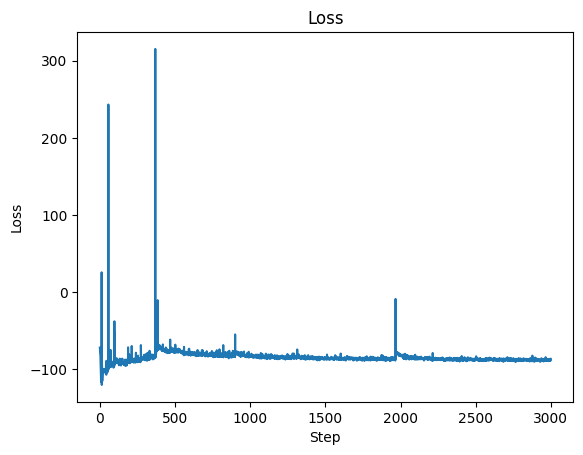

In [50]:
plt.plot(loss_arr_dist)
plt.title('Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [51]:
# Inference

# Sample points from warped space
with torch.no_grad():
  z_0 = proposal.sample(1000).squeeze()

# Apply HMC to points from warped space
chains = HMC(
            z_0,
            target,
            N_SAMPLES,
            BURN_IN,
            step_size = 0.3,
            num_leapfrog_steps = 7,
            verbose = False,
          )

# Apply RealNVP to chains and get final samples
with torch.no_grad():
  chains = chains.float()
  chains_no_grad = chains.detach().float()
  z = nfm.forward(chains_no_grad)

Sample: 100%|██████████| 1/1 [00:00, 11.36it/s, step size=2.40e+00, acc. prob=0.000]


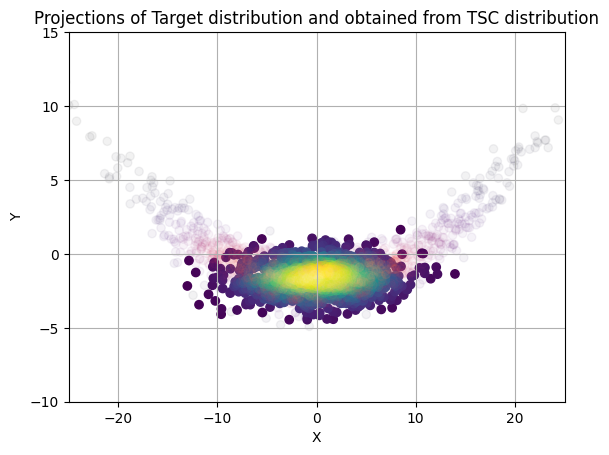

In [52]:
numpy_array = z.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Projections of Target distribution and obtained from TSC distribution')
ax.grid(True)
visualize_dist_(numpy_array, ax)
target.visualize_dist_nf(ax=ax, s=1000, nf = None, alpha=0.05)
ax.set_xlim(-25, 25)  # Adjust the limits as needed
ax.set_ylim(-10, 15)  # Adjust the limits as needed
plt.show()

In [53]:
# Calculate metrics

true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(), # True samples [num of samples, dim]
                      z.transpose(0,1).numpy(), # Generated samples [num_of_samples, num of chains, dim]
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.367, Std: 0.003. 
ESS: 0.486 
EMD: 2058.915


In [54]:
metrics

{'ess': 0.48633946646178816,
 'tv_mean': Array(0.36716583, dtype=float32),
 'tv_conf_sigma': Array(0.00334252, dtype=float32),
 'emd': 2058.914620962607}

### dim=100

In [84]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 100 # Dimension

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1
BURN_IN = 0
device="cpu"

In [85]:
# Define target and proposal

target = Banana(dim=dim, b=0.02)
proposal = nf.distributions.base.GaussianMixture(n_modes = 2, dim = latent_size, trainable=True)

In [86]:
# Define layers of RealNVP

K = 4
b = torch.Tensor([1] * (latent_size // 2) + [0] * (latent_size // 2))
flows = []
for g in range(K):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    if g % 2 == 0:
      flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
      flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
nfm = nf.NormalizingFlow(proposal, flows, target)

In [87]:
# Define optimizer and scheduler

optimizer_t = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_t = StepLR(optimizer_t, 1, gamma=1e-4)

In [88]:
# Training

torch.manual_seed(296)
n_iter = 3000

# magic params for loss
num_samples = 2 * 10
anneal_iter = 500

loss_arr_dist = []

for i in tqdm(range(n_iter)):

    optimizer_t.zero_grad()

    # Sample a point from warped space
    if i % 50 == 0:
      z_0 = proposal.sample(N_CHAINS).squeeze()

    # Apply HMC to this point in warped space
    chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size = 0.1,
                  num_leapfrog_steps = 10,
                  verbose = False,
                )
    chains = chains.float()
    chains_no_grad = chains.detach().float()

    # Apply RealNVP to the chain and get the final sample
    z = nfm.forward(chains_no_grad)

    if (i % 99 == 0):
      print("Scale:", proposal.log_scale)
      print("Loc:", proposal.loc)

    # Calculate loss
    loss_t = nfm.reverse_kld(num_samples, beta=np.min([1., 0.01 + i / anneal_iter]))
    loss_t.backward(retain_graph=True)

    # Return back to warped space
    z_0 = nfm.inverse(z).squeeze()
    optimizer_t.step()

    loss_arr_dist.append(loss_t.detach().item())

  0%|          | 0/3000 [00:00<?, ?it/s]

Sample: 100%|██████████| 1/1 [00:00, 37.86it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 1.4173e+0

Sample: 100%|██████████| 1/1 [00:00, 50.38it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5853e-03, -1.3089e-03,  8.9296e-04,  9.1828e-05,  7.9551e-03,
          -8.1314e-05,  1.3123e-03,  1.9899e-04, -2.3539e-03,  1.1968e-03,
           4.0925e-04, -6.1634e-04,  3.7181e-03,  1.6079e-03,  1.1903e-02,
           1.9426e-03,  1.0238e-02, -2.2249e-03,  4.1314e-03, -2.5678e-03,
           2.5759e-03, -1.0809e-03, -4.0615e-03, -3.7215e-03, -2.7574e-03,
          -1.7662e-04,  2.8623e-03,  1.5318e-02, -7.0894e-04, -3.4553e-03,
           1.3221e-03,  4.4307e-03,  3.3059e-03,  1.0640e-03, -9.6885e-04,
           9.4393e-03, -3.1937e-03,  2.0660e-03,  1.0051e-02,  1.5335e-03,
           2.6532e-03,  1.0513e-02,  1.3585e-02, -6.8713e-04, -9.4124e-04,
           3.8813e-04,  3.4077e-03,  1.2101e-02,  1.2899e-02,  5.0780e-03,
           2.5321e-03,  5.3676e-04,  3.2381e-03,  3.9355e-04, -2.3714e-03,
           1.6064e-02,  4.1606e-03,  5.6556e-03,  1.2686e-02,  1.1555e-02,
           4.1743e-03, -7.5478e-04,  5.8622e-03,  1.3100e-02,  2.0646e-

Sample: 100%|██████████| 1/1 [00:00, 61.24it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 42.37it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 51.58it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 39.92it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 55.45it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 48.22it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 52.88it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 43.32it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 46.41it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 39.86it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 54.08it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 34.10it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 50.14it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 44.10it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 56.38it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 44.66it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 50.39it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 44.27it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 38.43it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 53.17it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 47.20it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 44.04it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 52.00it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 42.93it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 52.27it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 48.16it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 62.93it/s, step size=8.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 47.70it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 51.80it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.5871e-03, -1.3107e-03,  8.9108e-04,  8.9947e-05,  7.9569e-03,
          -8.3195e-05,  1.3104e-03,  1.9711e-04, -2.3558e-03,  1.1949e-03,
           4.0737e-04, -6.1822e-04,  3.7162e-03,  1.6060e-03,  1.1905e-02,
           1.9407e-03,  1.0236e-02, -2.2268e-03,  4.1295e-03, -2.5697e-03,
           2.5740e-03, -1.0828e-03, -4.0634e-03, -3.7234e-03, -2.7593e-03,
          -1.7850e-04,  2.8604e-03,  1.5320e-02, -7.1082e-04, -3.4572e-03,
           1.3202e-03,  4.4288e-03,  3.3041e-03,  1.0621e-03, -9.7073e-04,
           9.4412e-03, -3.1955e-03,  2.0641e-03,  1.0049e-02,  1.5316e-03,
           2.6514e-03,  1.0515e-02,  1.3587e-02, -6.8901e-04, -9.4312e-04,
           3.8625e-04,  3.4058e-03,  1.2103e-02,  1.2901e-02,  5.0761e-03,
           2.5302e-03,  5.3488e-04,  3.2362e-03,  3.9167e-04, -2.3733e-03,
           1.6066e-02,  4.1588e-03,  5.6537e-03,  1.2688e-02,  1.1557e-02,
           4.1724e-03, -7.5666e-04,  5.8603e-03,  1.3102e-02,  2.0648e-

Sample: 100%|██████████| 1/1 [00:00, 43.61it/s, step size=3.20e+00, acc. prob=0.000]


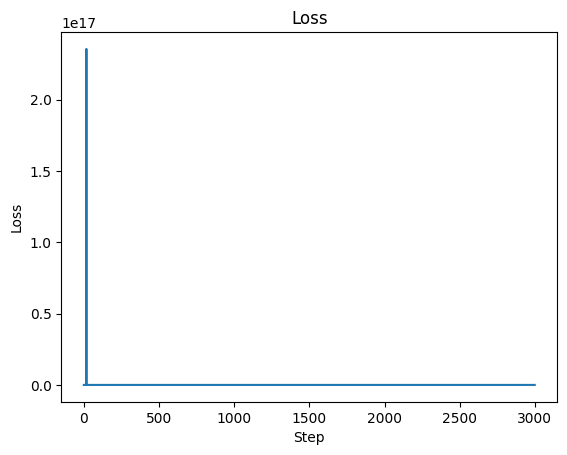

In [89]:
plt.plot(loss_arr_dist)
plt.title('Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

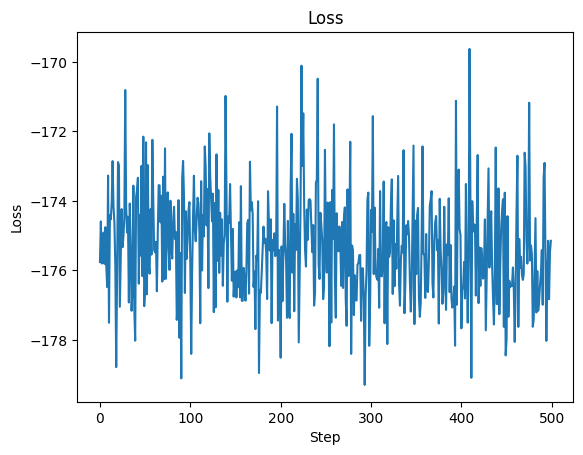

In [96]:
plt.plot(loss_arr_dist[-500:])
plt.title('Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [91]:
# Inference

# Sample points from warped space
with torch.no_grad():
  z_0 = proposal.sample(1000).squeeze()

# Apply HMC to points from warped space
chains = HMC(
            z_0,
            target,
            N_SAMPLES,
            BURN_IN,
            step_size = 0.3,
            num_leapfrog_steps = 7,
            verbose = False,
          )

# Apply RealNVP to chains and get final samples
with torch.no_grad():
  chains = chains.float()
  chains_no_grad = chains.detach().float()
  z = nfm.forward(chains_no_grad)

Sample: 100%|██████████| 1/1 [00:00,  6.49it/s, step size=2.40e+00, acc. prob=0.000]


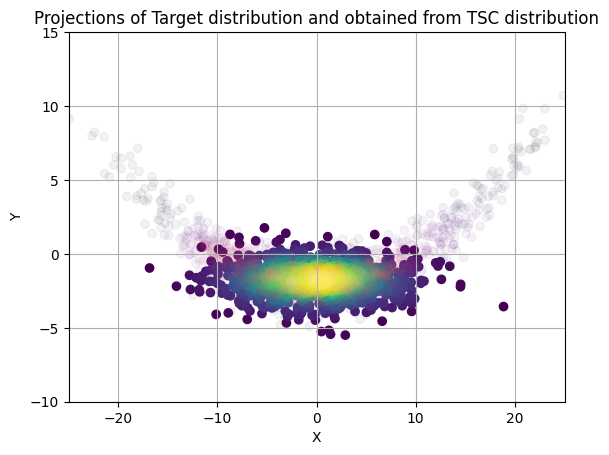

In [95]:
numpy_array = z.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Projections of Target distribution and obtained from TSC distribution')
ax.grid(True)
visualize_dist_(numpy_array, ax)
target.visualize_dist_nf(ax=ax, s=1000, nf = None, alpha=0.05)
ax.set_xlim(-25, 25)  # Adjust the limits as needed
ax.set_ylim(-10, 15)  # Adjust the limits as needed
plt.show()

In [93]:
# Calculate metrics

true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(), # True samples [num of samples, dim]
                      z.transpose(0,1).numpy(), # Generated samples [num_of_samples, num of chains, dim]
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.375, Std: 0.003. 
ESS: 0.490 
EMD: 4796.909


In [94]:
metrics

{'ess': 0.4899208096373819,
 'tv_mean': Array(0.37456256, dtype=float32),
 'tv_conf_sigma': Array(0.00250089, dtype=float32),
 'emd': 4796.90886276639}

## TSC implementation (with RealNVP) | Funnel



### dim=2

In [55]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 2 # Dimension

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1
BURN_IN = 0
device="cpu"

In [58]:
# Define target and proposal

target =  Funnel(num_dims=dim)
proposal = nf.distributions.base.GaussianMixture(n_modes = 2, dim = latent_size, trainable=True)

In [59]:
# Define layers of RealNVP

K = 4
b = torch.Tensor([1] * (latent_size // 2) + [0] * (latent_size // 2))
flows = []
for g in range(K):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    if g % 2 == 0:
      flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
      flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
nfm = nf.NormalizingFlow(proposal, flows, target)

In [60]:
# Define optimizer and scheduler

optimizer_t = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_t = StepLR(optimizer_t, 1, gamma=1e-4)

In [61]:
# Training

torch.manual_seed(296)
n_iter = 3000

# magic params for loss
num_samples = 2 * 10
anneal_iter = 500

loss_arr_dist = []

for i in tqdm(range(n_iter)):

    optimizer_t.zero_grad()

    # Sample a point from warped space
    if i % 50 == 0:
      z_0 = proposal.sample(N_CHAINS).squeeze()

    # Apply HMC to this point in warped space
    chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size = 0.1,
                  num_leapfrog_steps = 10,
                  verbose = False,
                )
    chains = chains.float()
    chains_no_grad = chains.detach().float()

    # Apply RealNVP to the chain and get the final sample
    z = nfm.forward(chains_no_grad)

    if (i % 99 == 0):
      print("Scale:", proposal.log_scale)
      print("Loc:", proposal.loc)

    # Calculate loss
    loss_t = nfm.reverse_kld(num_samples, beta=np.min([1., 0.01 + i / anneal_iter]))
    loss_t.backward(retain_graph=True)

    # Return back to warped space
    z_0 = nfm.inverse(z).squeeze()
    optimizer_t.step()

    loss_arr_dist.append(loss_t.detach().item())

  0%|          | 0/3000 [00:00<?, ?it/s]

Sample: 100%|██████████| 1/1 [00:00, 38.01it/s, step size=1.60e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[0., 0.],
         [0., 0.]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.3387,  0.5567],
         [ 0.8296, -1.0738]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 68.35it/s, step size=8.00e-01, acc. prob=0.984]


Scale: Parameter containing:
tensor([[[0.0387, 0.0393],
         [0.0288, 0.0604]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.3413,  0.6259],
         [ 0.9039, -1.1226]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 56.30it/s, step size=1.60e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[0.0317, 0.0326],
         [0.0319, 0.0774]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.3330,  0.6471],
         [ 0.9233, -1.0997]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 63.96it/s, step size=4.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[0.0211, 0.0260],
         [0.0298, 0.0621]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.3388,  0.6177],
         [ 0.9047, -1.0479]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 61.76it/s, step size=4.00e-01, acc. prob=0.933]


Scale: Parameter containing:
tensor([[[0.0125, 0.0098],
         [0.0290, 0.0467]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.3736,  0.5622],
         [ 0.8609, -1.0058]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 54.13it/s, step size=1.60e+00, acc. prob=0.028]


Scale: Parameter containing:
tensor([[[ 0.0091, -0.0087],
         [ 0.0260,  0.0315]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4111,  0.5259],
         [ 0.8173, -0.9720]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 38.86it/s, step size=1.60e+00, acc. prob=0.857]


Scale: Parameter containing:
tensor([[[ 0.0085, -0.0257],
         [ 0.0193,  0.0215]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4381,  0.5049],
         [ 0.7925, -0.9456]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 45.08it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0075, -0.0285],
         [ 0.0227,  0.0225]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4497,  0.4903],
         [ 0.7745, -0.9286]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 55.57it/s, step size=1.60e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0081, -0.0293],
         [ 0.0237,  0.0241]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4544,  0.4827],
         [ 0.7704, -0.9144]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 46.04it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0083, -0.0312],
         [ 0.0249,  0.0224]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4534,  0.4760],
         [ 0.7669, -0.9087]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 48.08it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0059, -0.0229],
         [ 0.0261,  0.0213]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4513,  0.4690],
         [ 0.7644, -0.9057]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 52.46it/s, step size=1.60e+00, acc. prob=0.619]


Scale: Parameter containing:
tensor([[[ 0.0116, -0.0123],
         [ 0.0252,  0.0227]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4400,  0.4636],
         [ 0.7621, -0.8977]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 46.48it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0189, -0.0075],
         [ 0.0251,  0.0188]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4487,  0.4535],
         [ 0.7498, -0.8896]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 41.99it/s, step size=1.60e+00, acc. prob=0.396]


Scale: Parameter containing:
tensor([[[ 0.0115, -0.0057],
         [ 0.0314,  0.0194]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4376,  0.4510],
         [ 0.7431, -0.8867]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 56.00it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0146, -0.0128],
         [ 0.0280,  0.0247]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4378,  0.4505],
         [ 0.7421, -0.8835]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 55.18it/s, step size=4.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[ 0.0124, -0.0065],
         [ 0.0348,  0.0264]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4298,  0.4430],
         [ 0.7375, -0.8744]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 31.51it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0046, -0.0092],
         [ 0.0321,  0.0236]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4259,  0.4320],
         [ 0.7315, -0.8661]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 45.65it/s, step size=8.00e-01, acc. prob=0.942]


Scale: Parameter containing:
tensor([[[ 0.0108, -0.0067],
         [ 0.0347,  0.0305]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4335,  0.4357],
         [ 0.7269, -0.8633]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 40.26it/s, step size=1.60e+00, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[ 0.0252, -0.0089],
         [ 0.0296,  0.0294]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4373,  0.4319],
         [ 0.7371, -0.8534]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 44.77it/s, step size=8.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[ 0.0163, -0.0081],
         [ 0.0302,  0.0376]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4325,  0.4334],
         [ 0.7433, -0.8596]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 51.91it/s, step size=1.60e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0131, -0.0103],
         [ 0.0414,  0.0412]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4351,  0.4249],
         [ 0.7436, -0.8524]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 59.30it/s, step size=8.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[ 0.0192, -0.0058],
         [ 0.0418,  0.0500]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4312,  0.4242],
         [ 0.7484, -0.8493]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 42.27it/s, step size=8.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[0.0172, 0.0076],
         [0.0325, 0.0433]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4201,  0.4261],
         [ 0.7388, -0.8470]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 53.03it/s, step size=8.00e-01, acc. prob=0.003]


Scale: Parameter containing:
tensor([[[ 0.0124, -0.0003],
         [ 0.0346,  0.0510]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4128,  0.4215],
         [ 0.7342, -0.8458]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 49.10it/s, step size=1.60e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[0.0069, 0.0001],
         [0.0398, 0.0522]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4124,  0.4166],
         [ 0.7306, -0.8463]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 57.62it/s, step size=8.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[0.0181, 0.0044],
         [0.0396, 0.0484]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4153,  0.4119],
         [ 0.7325, -0.8397]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 33.84it/s, step size=3.20e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[0.0174, 0.0055],
         [0.0314, 0.0502]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4124,  0.4100],
         [ 0.7307, -0.8461]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 44.93it/s, step size=1.60e+00, acc. prob=0.990]


Scale: Parameter containing:
tensor([[[ 0.0197, -0.0004],
         [ 0.0284,  0.0600]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4088,  0.4153],
         [ 0.7329, -0.8438]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 27.65it/s, step size=4.00e-01, acc. prob=0.962]


Scale: Parameter containing:
tensor([[[ 0.0217, -0.0044],
         [ 0.0376,  0.0648]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.4064,  0.4094],
         [ 0.7246, -0.8388]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 39.58it/s, step size=1.60e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[0.0084, 0.0055],
         [0.0303, 0.0590]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.3942,  0.4074],
         [ 0.7164, -0.8379]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 47.99it/s, step size=1.60e+00, acc. prob=0.023]


Scale: Parameter containing:
tensor([[[0.0345, 0.0055],
         [0.0298, 0.0590]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[-0.3982,  0.4043],
         [ 0.7210, -0.8324]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 46.28it/s, step size=1.60e+00, acc. prob=0.000]


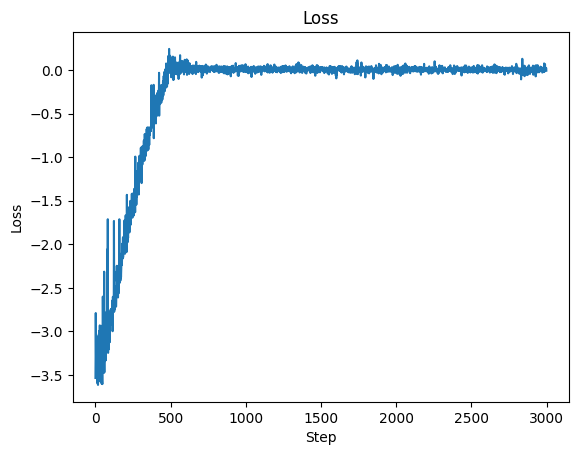

In [62]:
plt.plot(loss_arr_dist)
plt.title('Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [65]:
# Inference

# Sample points from warped space
with torch.no_grad():
  z_0 = proposal.sample(10000).squeeze()

# Apply HMC to points from warped space
chains = HMC(
            z_0,
            target,
            N_SAMPLES,
            BURN_IN,
            step_size = 0.3,
            num_leapfrog_steps = 7,
            verbose = False,
          )

# Apply RealNVP to chains and get final samples
with torch.no_grad():
  chains = chains.float()
  chains_no_grad = chains.detach().float()
  z = nfm.forward(chains_no_grad)

Sample: 100%|██████████| 1/1 [00:00, 27.00it/s, step size=6.00e-01, acc. prob=0.000]


In [67]:
def visualize_dist_nf(target, ax, s=1000, alpha=1.0, nf = None, cmap="magma"):
        """
        Visualizes distribution using sampled points and NF
        """
        # Generate points from distribution
        points = target.sample(s)
        if nf:
          points = nf(points).detach()
        X = points[:, 0]
        Y = points[:, 1]

        # Calculate the point density
        XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
        Z = gaussian_kde(XY)(XY)

        # Sort the points by density, so that the densest points are plotted last
        idx = Z.argsort()
        X, Y, Z = X[idx], Y[idx], Z[idx]

        ax.scatter(X, Y, c=Z, label=Z, alpha=alpha, cmap=cmap)
        # ax.colorbar()
        # ax.show()
        # ax.close()

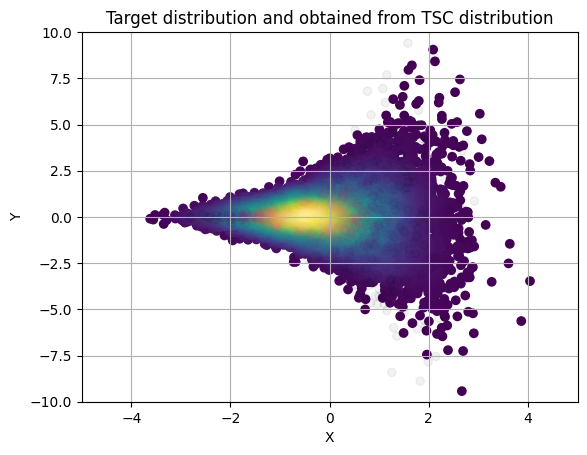

In [75]:
numpy_array = z.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from TSC distribution')
ax.grid(True)
visualize_dist_(numpy_array, ax)
visualize_dist_nf(target, ax=ax, s=1000, nf = None, alpha=0.05, cmap="magma")
ax.set_xlim(-5, 5)  # Adjust the limits as needed
ax.set_ylim(-10, 10)  # Adjust the limits as needed
plt.show()

In [76]:
# Calculate metrics

true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(), # True samples [num of samples, dim]
                      z.transpose(0,1).numpy(), # Generated samples [num_of_samples, num of chains, dim]
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.075, Std: 0.002. 
ESS: 1.000 
EMD: 1.552


In [77]:
metrics

{'ess': 1.0,
 'tv_mean': Array(0.07505866, dtype=float32),
 'tv_conf_sigma': Array(0.0018706, dtype=float32),
 'emd': 1.551975125853662}

### dim=10

In [104]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 10 # Dimension

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1
BURN_IN = 0
device="cpu"

In [105]:
# Define target and proposal

target =  Funnel(num_dims=dim)
proposal = nf.distributions.base.GaussianMixture(n_modes = 2, dim = latent_size, trainable=True)

In [106]:
# Define layers of RealNVP

K = 4
b = torch.Tensor([1] * (latent_size // 2) + [0] * (latent_size // 2))
flows = []
for g in range(K):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    if g % 2 == 0:
      flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
      flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
nfm = nf.NormalizingFlow(proposal, flows, target)

In [107]:
# Define optimizer and scheduler

optimizer_t = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_t = StepLR(optimizer_t, 1, gamma=1e-4)

In [108]:
# Training

torch.manual_seed(296)
n_iter = 3000

# magic params for loss
num_samples = 2 * 10
anneal_iter = 500

loss_arr_dist = []

for i in tqdm(range(n_iter)):

    optimizer_t.zero_grad()

    # Sample a point from warped space
    if i % 50 == 0:
      z_0 = proposal.sample(N_CHAINS).squeeze()

    # Apply HMC to this point in warped space
    chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size = 0.1,
                  num_leapfrog_steps = 10,
                  verbose = False,
                )
    chains = chains.float()
    chains_no_grad = chains.detach().float()

    # Apply RealNVP to the chain and get the final sample
    z = nfm.forward(chains_no_grad)

    if (i % 99 == 0):
      print("Scale:", proposal.log_scale)
      print("Loc:", proposal.loc)

    # Calculate loss
    loss_t = nfm.reverse_kld(num_samples, beta=np.min([1., 0.01 + i / anneal_iter]))
    loss_t.backward(retain_graph=True)

    # Return back to warped space
    z_0 = nfm.inverse(z).squeeze()
    optimizer_t.step()

    loss_arr_dist.append(loss_t.detach().item())

  0%|          | 0/3000 [00:00<?, ?it/s]

Sample: 100%|██████████| 1/1 [00:00, 50.20it/s, step size=8.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3603, -0.0404, -0.7976, -0.9699, -0.6927,  0.5435, -0.2820,
           0.2666,  0.2104, -1.4570],
         [ 0.6288, -0.8562,  1.5660, -1.6369, -1.2698,  2.6482, -0.4774,
           0.0049, -0.4076,  1.0247]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 67.87it/s, step size=8.00e-01, acc. prob=0.104]


Scale: Parameter containing:
tensor([[[-0.0065,  0.0341,  0.0722,  0.0448,  0.0677,  0.0834,  0.0925,
           0.0457,  0.0791,  0.0483],
         [-0.0003,  0.0210,  0.0195,  0.0188,  0.0224,  0.0214,  0.0214,
           0.0197,  0.0305,  0.0223]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.4240, -0.0557, -0.8581, -0.9853, -0.7022,  0.5546, -0.3268,
           0.2794,  0.2280, -1.4888],
         [ 0.6477, -0.8691,  1.5826, -1.6491, -1.2732,  2.6640, -0.4954,
           0.0203, -0.4216,  1.0341]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 72.66it/s, step size=4.00e-01, acc. prob=0.966]


Scale: Parameter containing:
tensor([[[-0.0248,  0.0401,  0.0521,  0.0594,  0.0686,  0.1038,  0.0809,
           0.0501,  0.0771,  0.0638],
         [-0.0008,  0.0209,  0.0197,  0.0189,  0.0224,  0.0216,  0.0215,
           0.0215,  0.0318,  0.0223]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.4235, -0.0553, -0.8396, -0.9700, -0.7100,  0.5584, -0.3024,
           0.2925,  0.2357, -1.4736],
         [ 0.6480, -0.8691,  1.5824, -1.6491, -1.2731,  2.6639, -0.4954,
           0.0203, -0.4215,  1.0340]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 53.26it/s, step size=1.60e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0340,  0.0443,  0.0524,  0.0599,  0.0662,  0.1101,  0.0860,
           0.0529,  0.0807,  0.0679],
         [-0.0012,  0.0209,  0.0199,  0.0192,  0.0224,  0.0224,  0.0215,
           0.0227,  0.0333,  0.0223]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.4259, -0.0553, -0.8348, -0.9681, -0.7133,  0.5212, -0.2959,
           0.2785,  0.2359, -1.4567],
         [ 0.6480, -0.8691,  1.5823, -1.6490, -1.2731,  2.6637, -0.4952,
           0.0203, -0.4214,  1.0339]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 56.86it/s, step size=4.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[-0.0409,  0.0393,  0.0497,  0.0613,  0.0647,  0.1102,  0.0862,
           0.0505,  0.0815,  0.0790],
         [-0.0017,  0.0209,  0.0198,  0.0192,  0.0224,  0.0232,  0.0216,
           0.0232,  0.0344,  0.0223]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.4254, -0.0609, -0.8279, -0.9698, -0.7128,  0.4930, -0.2869,
           0.2601,  0.2334, -1.4300],
         [ 0.6480, -0.8690,  1.5819, -1.6489, -1.2730,  2.6633, -0.4951,
           0.0202, -0.4212,  1.0337]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 63.05it/s, step size=1.60e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0481,  0.0257,  0.0475,  0.0515,  0.0580,  0.1009,  0.0813,
           0.0433,  0.0777,  0.0885],
         [-0.0022,  0.0209,  0.0197,  0.0191,  0.0224,  0.0235,  0.0215,
           0.0219,  0.0340,  0.0223]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.4219, -0.0625, -0.8205, -0.9671, -0.7056,  0.5058, -0.2858,
           0.2495,  0.2244, -1.3938],
         [ 0.6478, -0.8690,  1.5815, -1.6488, -1.2730,  2.6630, -0.4950,
           0.0202, -0.4210,  1.0335]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 74.77it/s, step size=4.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[-0.0554,  0.0165,  0.0429,  0.0388,  0.0486,  0.0841,  0.0727,
           0.0344,  0.0702,  0.0831],
         [-0.0025,  0.0208,  0.0194,  0.0188,  0.0223,  0.0233,  0.0214,
           0.0203,  0.0328,  0.0222]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.4179, -0.0658, -0.8096, -0.9651, -0.7003,  0.5323, -0.2870,
           0.2427,  0.2170, -1.3663],
         [ 0.6475, -0.8690,  1.5812, -1.6487, -1.2729,  2.6627, -0.4949,
           0.0202, -0.4208,  1.0334]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 56.09it/s, step size=8.00e-01, acc. prob=0.353]


Scale: Parameter containing:
tensor([[[-0.0577,  0.0088,  0.0390,  0.0377,  0.0444,  0.0755,  0.0636,
           0.0273,  0.0639,  0.0843],
         [-0.0029,  0.0208,  0.0194,  0.0185,  0.0223,  0.0230,  0.0213,
           0.0194,  0.0320,  0.0222]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.4114, -0.0706, -0.8012, -0.9674, -0.6948,  0.5591, -0.2890,
           0.2370,  0.2110, -1.3405],
         [ 0.6472, -0.8689,  1.5809, -1.6486, -1.2728,  2.6625, -0.4949,
           0.0202, -0.4207,  1.0332]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 72.75it/s, step size=8.00e-01, acc. prob=0.316]


Scale: Parameter containing:
tensor([[[-0.0575,  0.0071,  0.0364,  0.0400,  0.0403,  0.0671,  0.0561,
           0.0230,  0.0584,  0.0904],
         [-0.0031,  0.0207,  0.0191,  0.0183,  0.0222,  0.0227,  0.0213,
           0.0183,  0.0311,  0.0222]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.4038, -0.0772, -0.7969, -0.9683, -0.6918,  0.5979, -0.2936,
           0.2300,  0.2008, -1.3141],
         [ 0.6471, -0.8688,  1.5807, -1.6485, -1.2727,  2.6623, -0.4948,
           0.0202, -0.4205,  1.0330]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 64.74it/s, step size=8.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[-0.0569,  0.0034,  0.0358,  0.0363,  0.0349,  0.0544,  0.0461,
           0.0173,  0.0530,  0.0936],
         [-0.0033,  0.0207,  0.0192,  0.0182,  0.0222,  0.0224,  0.0211,
           0.0178,  0.0301,  0.0222]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3974, -0.0856, -0.7886, -0.9753, -0.6942,  0.6272, -0.2977,
           0.2265,  0.1959, -1.2918],
         [ 0.6469, -0.8687,  1.5804, -1.6483, -1.2726,  2.6622, -0.4949,
           0.0202, -0.4203,  1.0329]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 55.21it/s, step size=4.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0557,  0.0056,  0.0345,  0.0345,  0.0311,  0.0488,  0.0359,
           0.0133,  0.0502,  0.0944],
         [-0.0034,  0.0207,  0.0192,  0.0180,  0.0222,  0.0223,  0.0210,
           0.0172,  0.0292,  0.0222]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3914, -0.0954, -0.7810, -0.9868, -0.6987,  0.6583, -0.2941,
           0.2241,  0.1906, -1.2690],
         [ 0.6467, -0.8686,  1.5801, -1.6482, -1.2725,  2.6620, -0.4949,
           0.0202, -0.4202,  1.0327]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 58.83it/s, step size=8.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0532,  0.0068,  0.0354,  0.0389,  0.0282,  0.0495,  0.0268,
           0.0085,  0.0442,  0.1013],
         [-0.0035,  0.0206,  0.0192,  0.0178,  0.0222,  0.0221,  0.0209,
           0.0160,  0.0286,  0.0222]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3838, -0.1077, -0.7719, -1.0006, -0.7019,  0.6874, -0.2963,
           0.2216,  0.1837, -1.2440],
         [ 0.6465, -0.8685,  1.5798, -1.6481, -1.2724,  2.6619, -0.4948,
           0.0202, -0.4200,  1.0326]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 41.60it/s, step size=1.60e+00, acc. prob=0.025]


Scale: Parameter containing:
tensor([[[-0.0493,  0.0093,  0.0371,  0.0432,  0.0215,  0.0467,  0.0197,
           0.0081,  0.0425,  0.1081],
         [-0.0035,  0.0206,  0.0195,  0.0178,  0.0221,  0.0218,  0.0208,
           0.0156,  0.0279,  0.0222]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3758, -0.1189, -0.7632, -1.0059, -0.7138,  0.7213, -0.2978,
           0.2152,  0.1785, -1.2233],
         [ 0.6464, -0.8684,  1.5795, -1.6480, -1.2723,  2.6617, -0.4948,
           0.0202, -0.4199,  1.0325]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 37.87it/s, step size=8.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[-0.0469,  0.0061,  0.0372,  0.0442,  0.0171,  0.0455,  0.0148,
           0.0052,  0.0409,  0.1175],
         [-0.0035,  0.0206,  0.0198,  0.0177,  0.0221,  0.0218,  0.0208,
           0.0149,  0.0274,  0.0222]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3698, -0.1297, -0.7523, -1.0177, -0.7175,  0.7475, -0.2961,
           0.2124,  0.1714, -1.2035],
         [ 0.6463, -0.8683,  1.5792, -1.6479, -1.2722,  2.6616, -0.4948,
           0.0202, -0.4197,  1.0324]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 35.85it/s, step size=1.60e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0439,  0.0042,  0.0396,  0.0362,  0.0113,  0.0388,  0.0114,
           0.0056,  0.0386,  0.1233],
         [-0.0035,  0.0206,  0.0202,  0.0177,  0.0221,  0.0217,  0.0207,
           0.0141,  0.0269,  0.0223]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3631, -0.1451, -0.7407, -1.0352, -0.7327,  0.7715, -0.2958,
           0.2115,  0.1649, -1.1831],
         [ 0.6461, -0.8683,  1.5788, -1.6477, -1.2721,  2.6614, -0.4949,
           0.0202, -0.4196,  1.0322]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 37.00it/s, step size=1.60e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0410,  0.0016,  0.0419,  0.0295,  0.0098,  0.0404,  0.0088,
           0.0052,  0.0373,  0.1300],
         [-0.0035,  0.0206,  0.0203,  0.0176,  0.0221,  0.0217,  0.0206,
           0.0139,  0.0266,  0.0224]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3564, -0.1594, -0.7296, -1.0454, -0.7431,  0.7971, -0.2979,
           0.2099,  0.1555, -1.1662],
         [ 0.6461, -0.8682,  1.5784, -1.6476, -1.2720,  2.6613, -0.4948,
           0.0203, -0.4194,  1.0321]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 40.61it/s, step size=1.60e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0356,  0.0030,  0.0442,  0.0326,  0.0040,  0.0411,  0.0086,
           0.0054,  0.0360,  0.1364],
         [-0.0035,  0.0206,  0.0209,  0.0176,  0.0221,  0.0214,  0.0206,
           0.0128,  0.0267,  0.0224]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3487, -0.1745, -0.7189, -1.0577, -0.7522,  0.8216, -0.2981,
           0.2076,  0.1510, -1.1438],
         [ 0.6460, -0.8681,  1.5780, -1.6475, -1.2720,  2.6612, -0.4948,
           0.0203, -0.4193,  1.0320]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 49.14it/s, step size=8.00e-01, acc. prob=0.049]


Scale: Parameter containing:
tensor([[[-0.0312,  0.0044,  0.0464,  0.0311,  0.0005,  0.0493,  0.0080,
           0.0077,  0.0354,  0.1425],
         [-0.0035,  0.0206,  0.0214,  0.0175,  0.0221,  0.0212,  0.0205,
           0.0121,  0.0268,  0.0225]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3407, -0.1845, -0.7071, -1.0785, -0.7632,  0.8491, -0.3004,
           0.2025,  0.1456, -1.1262],
         [ 0.6460, -0.8680,  1.5776, -1.6474, -1.2719,  2.6611, -0.4948,
           0.0203, -0.4192,  1.0319]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 54.58it/s, step size=8.00e-01, acc. prob=0.009]


Scale: Parameter containing:
tensor([[[-0.0279, -0.0039,  0.0512,  0.0234, -0.0005,  0.0596,  0.0095,
           0.0112,  0.0347,  0.1508],
         [-0.0034,  0.0206,  0.0217,  0.0178,  0.0221,  0.0212,  0.0205,
           0.0114,  0.0270,  0.0226]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3341, -0.2043, -0.6948, -1.0911, -0.7721,  0.8700, -0.2970,
           0.2002,  0.1392, -1.1074],
         [ 0.6460, -0.8679,  1.5773, -1.6473, -1.2719,  2.6609, -0.4948,
           0.0203, -0.4191,  1.0317]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 37.46it/s, step size=1.60e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0247, -0.0080,  0.0560,  0.0181, -0.0052,  0.0655,  0.0070,
           0.0096,  0.0347,  0.1582],
         [-0.0035,  0.0207,  0.0222,  0.0177,  0.0221,  0.0214,  0.0205,
           0.0107,  0.0271,  0.0227]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3275, -0.2137, -0.6818, -1.1086, -0.7819,  0.8951, -0.2990,
           0.1950,  0.1361, -1.0903],
         [ 0.6460, -0.8678,  1.5769, -1.6472, -1.2718,  2.6608, -0.4948,
           0.0203, -0.4189,  1.0316]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 60.15it/s, step size=4.00e-01, acc. prob=0.966]


Scale: Parameter containing:
tensor([[[-0.0213, -0.0076,  0.0612,  0.0135, -0.0119,  0.0770,  0.0072,
           0.0113,  0.0333,  0.1650],
         [-0.0034,  0.0207,  0.0229,  0.0178,  0.0221,  0.0217,  0.0204,
           0.0105,  0.0271,  0.0227]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3211, -0.2251, -0.6668, -1.1224, -0.7965,  0.9132, -0.2987,
           0.1878,  0.1334, -1.0751],
         [ 0.6460, -0.8677,  1.5764, -1.6471, -1.2717,  2.6607, -0.4948,
           0.0204, -0.4189,  1.0315]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 53.50it/s, step size=1.60e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0188, -0.0051,  0.0652,  0.0090, -0.0065,  0.0774,  0.0062,
           0.0113,  0.0332,  0.1732],
         [-0.0034,  0.0207,  0.0237,  0.0178,  0.0221,  0.0219,  0.0204,
           0.0107,  0.0272,  0.0228]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3157, -0.2400, -0.6530, -1.1308, -0.8048,  0.9348, -0.2976,
           0.1872,  0.1254, -1.0557],
         [ 0.6461, -0.8676,  1.5759, -1.6470, -1.2716,  2.6605, -0.4949,
           0.0204, -0.4188,  1.0314]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 53.64it/s, step size=8.00e-01, acc. prob=0.007]


Scale: Parameter containing:
tensor([[[-0.0169, -0.0069,  0.0694,  0.0097, -0.0137,  0.0819,  0.0099,
           0.0095,  0.0338,  0.1708],
         [-0.0035,  0.0207,  0.0244,  0.0178,  0.0221,  0.0224,  0.0204,
           0.0104,  0.0275,  0.0229]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3115, -0.2499, -0.6395, -1.1403, -0.8161,  0.9501, -0.2947,
           0.1760,  0.1251, -1.0402],
         [ 0.6461, -0.8676,  1.5755, -1.6469, -1.2716,  2.6604, -0.4949,
           0.0204, -0.4187,  1.0314]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 54.20it/s, step size=8.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0125, -0.0032,  0.0726,  0.0101, -0.0152,  0.0838,  0.0094,
           0.0109,  0.0341,  0.1724],
         [-0.0034,  0.0207,  0.0254,  0.0182,  0.0221,  0.0236,  0.0204,
           0.0111,  0.0272,  0.0230]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3057, -0.2545, -0.6269, -1.1489, -0.8288,  0.9649, -0.2951,
           0.1727,  0.1214, -1.0173],
         [ 0.6461, -0.8675,  1.5750, -1.6469, -1.2715,  2.6603, -0.4948,
           0.0205, -0.4185,  1.0313]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 55.78it/s, step size=8.00e-01, acc. prob=0.803]


Scale: Parameter containing:
tensor([[[-0.0081, -0.0043,  0.0768,  0.0135, -0.0126,  0.0962,  0.0082,
           0.0092,  0.0336,  0.1864],
         [-0.0034,  0.0207,  0.0260,  0.0182,  0.0221,  0.0242,  0.0204,
           0.0110,  0.0278,  0.0231]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.3012, -0.2632, -0.6115, -1.1607, -0.8356,  0.9813, -0.2953,
           0.1638,  0.1157, -1.0046],
         [ 0.6462, -0.8675,  1.5745, -1.6467, -1.2715,  2.6602, -0.4948,
           0.0206, -0.4183,  1.0312]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 32.59it/s, step size=8.00e-01, acc. prob=0.584]


Scale: Parameter containing:
tensor([[[-0.0060, -0.0015,  0.0802,  0.0052, -0.0111,  0.0936,  0.0084,
           0.0069,  0.0345,  0.1934],
         [-0.0035,  0.0207,  0.0269,  0.0184,  0.0222,  0.0244,  0.0204,
           0.0112,  0.0280,  0.0231]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.2949, -0.2770, -0.6014, -1.1734, -0.8343,  1.0036, -0.2945,
           0.1578,  0.1090, -0.9865],
         [ 0.6463, -0.8674,  1.5741, -1.6466, -1.2715,  2.6601, -0.4949,
           0.0207, -0.4182,  1.0311]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 49.51it/s, step size=1.60e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0023,  0.0031,  0.0859,  0.0017, -0.0043,  0.0979,  0.0129,
           0.0062,  0.0357,  0.1968],
         [-0.0034,  0.0207,  0.0277,  0.0187,  0.0221,  0.0255,  0.0204,
           0.0108,  0.0281,  0.0232]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.2893, -0.2856, -0.5913, -1.1883, -0.8423,  1.0223, -0.2967,
           0.1597,  0.1102, -0.9694],
         [ 0.6464, -0.8673,  1.5737, -1.6465, -1.2714,  2.6600, -0.4948,
           0.0207, -0.4181,  1.0310]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 59.67it/s, step size=8.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[ 0.0054,  0.0074,  0.0900,  0.0085, -0.0016,  0.1006,  0.0147,
           0.0069,  0.0353,  0.1961],
         [-0.0034,  0.0207,  0.0284,  0.0185,  0.0221,  0.0269,  0.0203,
           0.0113,  0.0290,  0.0233]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.2857, -0.2835, -0.5817, -1.1871, -0.8452,  1.0317, -0.2924,
           0.1547,  0.1096, -0.9578],
         [ 0.6464, -0.8673,  1.5732, -1.6465, -1.2714,  2.6598, -0.4949,
           0.0207, -0.4181,  1.0310]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 40.64it/s, step size=8.00e-01, acc. prob=0.026]


Scale: Parameter containing:
tensor([[[ 0.0095,  0.0138,  0.0954,  0.0148,  0.0011,  0.1045,  0.0181,
           0.0023,  0.0322,  0.2080],
         [-0.0034,  0.0207,  0.0293,  0.0186,  0.0222,  0.0283,  0.0202,
           0.0113,  0.0301,  0.0233]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.2820, -0.2912, -0.5692, -1.1864, -0.8557,  1.0400, -0.2944,
           0.1518,  0.1037, -0.9457],
         [ 0.6466, -0.8673,  1.5727, -1.6465, -1.2714,  2.6596, -0.4949,
           0.0208, -0.4180,  1.0309]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 51.40it/s, step size=1.60e+00, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[ 0.0135,  0.0199,  0.1004,  0.0284,  0.0096,  0.1097,  0.0215,
           0.0004,  0.0335,  0.2092],
         [-0.0034,  0.0207,  0.0301,  0.0183,  0.0222,  0.0286,  0.0202,
           0.0131,  0.0308,  0.0234]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.2778, -0.2896, -0.5621, -1.1835, -0.8575,  1.0558, -0.2945,
           0.1477,  0.1027, -0.9234],
         [ 0.6467, -0.8672,  1.5723, -1.6464, -1.2713,  2.6596, -0.4949,
           0.0209, -0.4180,  1.0308]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 58.47it/s, step size=4.00e-01, acc. prob=0.813]


Scale: Parameter containing:
tensor([[[ 0.0232,  0.0295,  0.1085,  0.0353,  0.0151,  0.1066,  0.0257,
           0.0020,  0.0310,  0.2124],
         [-0.0034,  0.0206,  0.0306,  0.0183,  0.0221,  0.0304,  0.0202,
           0.0126,  0.0306,  0.0235]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.2713, -0.2946, -0.5521, -1.1779, -0.8606,  1.0754, -0.2943,
           0.1433,  0.1051, -0.9051],
         [ 0.6469, -0.8671,  1.5717, -1.6464, -1.2713,  2.6594, -0.4948,
           0.0210, -0.4179,  1.0307]]], requires_grad=True)


Sample: 100%|██████████| 1/1 [00:00, 62.08it/s, step size=4.00e-01, acc. prob=0.661]


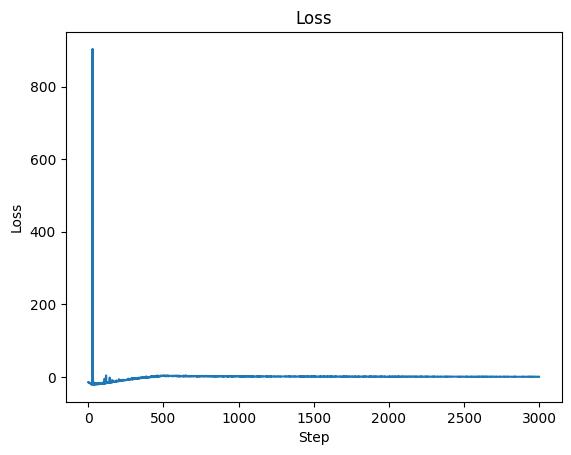

In [109]:
plt.plot(loss_arr_dist)
plt.title('Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

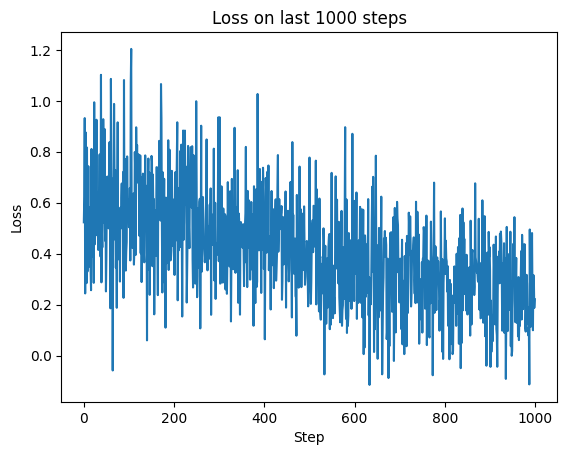

In [113]:
plt.plot(loss_arr_dist[-1000:])
plt.title('Loss on last 1000 steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [114]:
# Inference

# Sample points from warped space
with torch.no_grad():
  z_0 = proposal.sample(10000).squeeze()

# Apply HMC to points from warped space
chains = HMC(
            z_0,
            target,
            N_SAMPLES,
            BURN_IN,
            step_size = 0.3,
            num_leapfrog_steps = 7,
            verbose = False,
          )

# Apply RealNVP to chains and get final samples
with torch.no_grad():
  chains = chains.float()
  chains_no_grad = chains.detach().float()
  z = nfm.forward(chains_no_grad)

Sample: 100%|██████████| 1/1 [00:00,  2.23it/s, step size=6.00e-01, acc. prob=0.000]


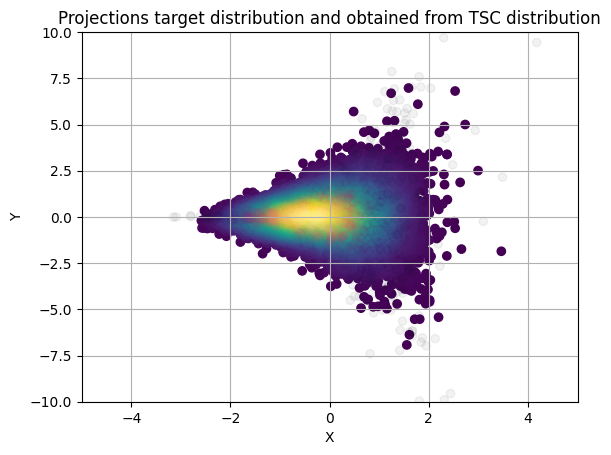

In [120]:
numpy_array = z.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Projections target distribution and obtained from TSC distribution')
ax.grid(True)
visualize_dist_(numpy_array, ax)
visualize_dist_nf(target, ax=ax, s=1000, nf = None, alpha=0.05, cmap="magma")
ax.set_xlim(-5, 5)  # Adjust the limits as needed
ax.set_ylim(-10, 10)  # Adjust the limits as needed
plt.show()

In [115]:
# Calculate metrics

true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(), # True samples [num of samples, dim]
                      z.transpose(0,1).numpy(), # Generated samples [num_of_samples, num of chains, dim]
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.126, Std: 0.003. 
ESS: 1.000 
EMD: 37.126


In [116]:
metrics

{'ess': 1.0,
 'tv_mean': Array(0.12640853, dtype=float32),
 'tv_conf_sigma': Array(0.00260426, dtype=float32),
 'emd': 37.126217427713804}

### dim=50 (1)

In [173]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 50 # Dimension

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1
BURN_IN = 0
device="cpu"

In [174]:
# Define target and proposal

target =  Funnel(num_dims=dim)
proposal = nf.distributions.base.GaussianMixture(n_modes = 2, dim = latent_size, trainable=True)

In [175]:
# Define layers of RealNVP

K = 3
b = torch.Tensor([1] * (latent_size // 2) + [0] * (latent_size // 2))
flows = []
for g in range(K):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    if g % 2 == 0:
      flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
      flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
nfm = nf.NormalizingFlow(proposal, flows, target)

In [176]:
# Define optimizer and scheduler

optimizer_t = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_t = StepLR(optimizer_t, 1, gamma=1e-4)

In [177]:
# Training

torch.manual_seed(296)
n_iter = 2000

# magic params for loss
num_samples = 2 * 10
anneal_iter = 500

loss_arr_dist = []

for i in tqdm(range(n_iter)):

    optimizer_t.zero_grad()

    # Sample a point from warped space
    if i % 50 == 0:
      z_0 = proposal.sample(N_CHAINS).squeeze()

    # Apply HMC to this point in warped space
    chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size = 0.1,
                  num_leapfrog_steps = 10,
                  verbose = False,
                )
    chains = chains.float()
    chains_no_grad = chains.detach().float()

    # Apply RealNVP to the chain and get the final sample
    z = nfm.forward(chains_no_grad)

    if (i % 99 == 0):
      print("Scale:", proposal.log_scale)
      print("Loc:", proposal.loc)

    # Calculate loss
    loss_t = nfm.reverse_kld(num_samples, beta=np.min([1., 0.01 + i / anneal_iter]))
    loss_t.backward(retain_graph=True)

    # Return back to warped space
    z_0 = nfm.inverse(z).squeeze()
    optimizer_t.step()

    loss_arr_dist.append(loss_t.detach().item())

  0%|          | 0/2000 [00:00<?, ?it/s]

Sample: 100%|██████████| 1/1 [00:00, 33.11it/s, step size=8.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 1.3635e-01, -5.1740e-01,  1.0262e+00,  1.8288e-01,  9.7832e-01,
           2.1387e+00, -5.2805e-01,  1.2316e+00,  5.5470e-01,  4.4551e-01,
          -2.1192e-01, -4.0302e-01,  1.5779e-01, -8.1530e-02, -2.2951e-01,
          -5.3842e-04, -6.3796e-01, -2.1970e-01,  2.1527e+00,  9.6344e-01,
          -5.8007e-01,  8.7150e-02, -1.2010e-01, -1.0017e+00,  1.4964e+00,
          -1.7270e-02, -1.2001e+00,  6.9135e-01,  7.6294e-01, -2.6216e-01,
          

Sample: 100%|██████████| 1/1 [00:00, 72.42it/s, step size=8.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-5.7733e-03,  2.8149e-03,  1.4627e-02,  9.1797e-03,  2.0293e-02,
           8.5058e-03,  1.0922e-02, -4.3529e-03,  2.9961e-02, -1.1790e-05,
           1.1384e-02,  1.3787e-02,  6.0902e-03,  3.7924e-02,  1.9781e-02,
           3.6002e-03, -2.7632e-03,  1.4503e-02,  1.5130e-02,  6.3392e-03,
           1.3762e-02,  2.4699e-03, -3.3886e-03, -5.1411e-03,  3.7749e-02,
          -4.6484e-03,  1.1101e-02,  1.6800e-04,  1.7964e-02,  2.1593e-03,
           1.8806e-02,  6.0498e-03,  8.1267e-03,  2.1638e-02,  2.0087e-02,
           4.9659e-03,  8.1838e-03,  2.0088e-02,  1.8715e-03,  1.0753e-02,
           1.8266e-02,  3.0454e-02,  4.0483e-02,  1.4867e-02,  3.8590e-03,
           1.0210e-02,  2.8702e-03,  4.0907e-02,  1.6226e-02,  1.9051e-02],
         [-7.7850e-05,  4.4119e-03, -5.4329e-03, -4.7499e-03, -8.0123e-03,
           9.3832e-03,  1.6343e-02,  3.8122e-03,  1.5691e-02,  1.4780e-02,
           2.2717e-03, -1.3309e-03, -6.9558e-03, -6.1020e-03,  1.8875e

Sample: 100%|██████████| 1/1 [00:00, 57.57it/s, step size=8.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0162, -0.0083,  0.0249, -0.0018,  0.0095,  0.0193, -0.0002,
          -0.0153,  0.0192,  0.0103,  0.0218,  0.0028, -0.0049,  0.0487,
           0.0093, -0.0074, -0.0141,  0.0035,  0.0040, -0.0044,  0.0242,
          -0.0085, -0.0143, -0.0161,  0.0273, -0.0156,  0.0216, -0.0109,
           0.0284, -0.0090,  0.0292,  0.0164, -0.0029,  0.0322,  0.0090,
          -0.0060,  0.0186,  0.0096, -0.0092, -0.0002,  0.0074,  0.0199,
           0.0281,  0.0039, -0.0071,  0.0212,  0.0132,  0.0517,  0.0055,
           0.0080],
         [ 0.0011,  0.0026, -0.0056, -0.0050, -0.0086,  0.0039,  0.0061,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0134, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0014,  0.0070, -0.0069,  0.0055,
          -0.0020, -0.0076,  0.0069, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0048,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 38.90it/s, step size=2.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0169,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 60.47it/s, step size=2.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 58.87it/s, step size=2.00e-01, acc. prob=0.889]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 55.89it/s, step size=4.00e-01, acc. prob=0.150]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 67.07it/s, step size=8.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 69.59it/s, step size=4.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 61.75it/s, step size=8.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 46.88it/s, step size=4.00e-01, acc. prob=0.251]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 56.12it/s, step size=8.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 58.86it/s, step size=2.00e-01, acc. prob=0.679]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 65.05it/s, step size=4.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 47.77it/s, step size=4.00e-01, acc. prob=0.626]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 52.08it/s, step size=8.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 53.67it/s, step size=8.00e-01, acc. prob=0.634]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 62.73it/s, step size=4.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 56.02it/s, step size=8.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 60.52it/s, step size=4.00e-01, acc. prob=0.318]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 41.13it/s, step size=2.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0187, -0.0109,  0.0275, -0.0044,  0.0070,  0.0219, -0.0027,
          -0.0179,  0.0166,  0.0129,  0.0243,  0.0002, -0.0075,  0.0513,
           0.0068, -0.0099, -0.0166,  0.0010,  0.0014, -0.0069,  0.0268,
          -0.0111, -0.0169, -0.0187,  0.0247, -0.0182,  0.0242, -0.0135,
           0.0310, -0.0116,  0.0318,  0.0190, -0.0054,  0.0347,  0.0064,
          -0.0085,  0.0212,  0.0070, -0.0118, -0.0027,  0.0048,  0.0174,
           0.0255,  0.0013, -0.0096,  0.0237,  0.0157,  0.0543,  0.0029,
           0.0054],
         [ 0.0011,  0.0025, -0.0056, -0.0050, -0.0086,  0.0038,  0.0059,
           0.0036,  0.0135,  0.0147,  0.0015, -0.0136, -0.0067, -0.0072,
           0.0187,  0.0180, -0.0056,  0.0012,  0.0069, -0.0069,  0.0055,
          -0.0021, -0.0076,  0.0068, -0.0055,  0.0191, -0.0069,  0.0169,
          -0.0065,  0.0203,  0.0100,  0.0145,  0.0095,  0.0067,  0.0168,
           0.0232,  0.0056,  0.0075,  0.0220,  0.0073,  0.0045,  0.0005,
  

Sample: 100%|██████████| 1/1 [00:00, 56.78it/s, step size=2.00e-01, acc. prob=0.000]


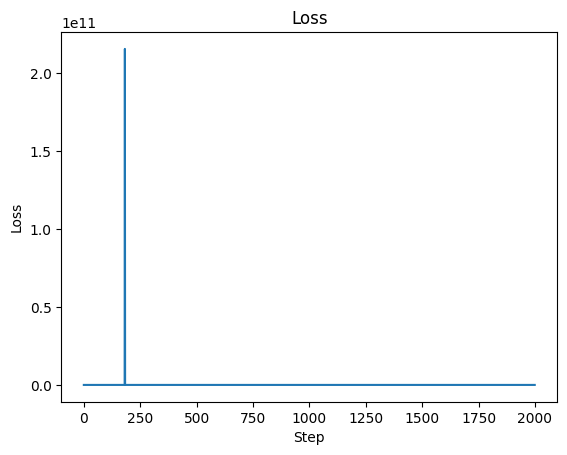

In [178]:
plt.plot(loss_arr_dist)
plt.title('Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

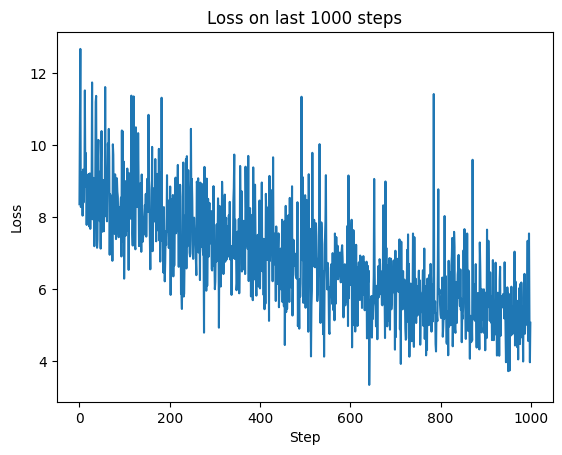

In [179]:
plt.plot(loss_arr_dist[-1000:])
plt.title('Loss on last 1000 steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [180]:
# Inference

# Sample points from warped space
with torch.no_grad():
  z_0 = proposal.sample(10000).squeeze()

# Apply HMC to points from warped space
chains = HMC(
            z_0,
            target,
            N_SAMPLES,
            BURN_IN,
            step_size = 0.3,
            num_leapfrog_steps = 7,
            verbose = False,
          )

# Apply RealNVP to chains and get final samples
with torch.no_grad():
  chains = chains.float()
  chains_no_grad = chains.detach().float()
  z = nfm.forward(chains_no_grad)

Sample: 100%|██████████| 1/1 [00:01,  1.30s/it, step size=7.50e-02, acc. prob=1.000]


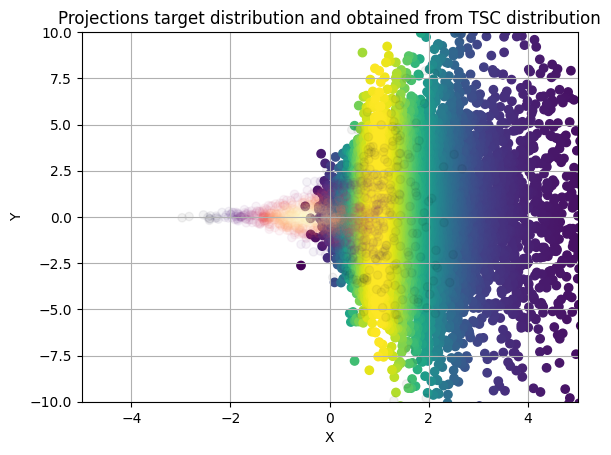

In [181]:
numpy_array = z.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Projections target distribution and obtained from TSC distribution')
ax.grid(True)
visualize_dist_(numpy_array, ax)
visualize_dist_nf(target, ax=ax, s=1000, nf = None, alpha=0.05, cmap="magma")
ax.set_xlim(-5, 5)  # Adjust the limits as needed
ax.set_ylim(-10, 10)  # Adjust the limits as needed
plt.show()

In [182]:
# Calculate metrics

true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(), # True samples [num of samples, dim]
                      z.transpose(0,1).numpy(), # Generated samples [num_of_samples, num of chains, dim]
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

/tsc_msc_dl/metrics.py:37: RuntimeWarning: invalid value encountered in subtract
  xs_pred[::ess_rar] - xs_pred[::ess_rar].mean(0)[None, ...],


  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.380, Std: 0.040. 
ESS: nan 
EMD: 246002815.227


In [183]:
metrics

{'ess': nan,
 'tv_mean': Array(0.3802794, dtype=float32),
 'tv_conf_sigma': Array(0.039609, dtype=float32),
 'emd': 246002815.2272704}

### dim=50 (2)

In [250]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 50 # Dimension

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1
BURN_IN = 0
device="cpu"

In [251]:
# Define target and proposal

target =  Funnel(num_dims=dim)
proposal = nf.distributions.base.GaussianMixture(n_modes = 2, dim = latent_size, trainable=True)

In [252]:
# Define layers of RealNVP

K = 4
b = torch.Tensor([1] * (latent_size // 2) + [0] * (latent_size // 2))
flows = []
for g in range(K):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    if g % 2 == 0:
      flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
      flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
nfm = nf.NormalizingFlow(proposal, flows, target)

In [253]:
# Define optimizer and scheduler

optimizer_t = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_t = StepLR(optimizer_t, 1, gamma=1e-4)

In [254]:
# Training

torch.manual_seed(296)
n_iter = 1000

# magic params for loss
num_samples = 2 * 10
anneal_iter = 500

loss_arr_dist = []

for i in tqdm(range(n_iter)):

    optimizer_t.zero_grad()

    # Sample a point from warped space
    if i % 50 == 0:
      z_0 = proposal.sample(N_CHAINS).squeeze()

    # Apply HMC to this point in warped space
    chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size = 0.1,
                  num_leapfrog_steps = 10,
                  verbose = False,
                )
    chains = chains.float()
    chains_no_grad = chains.detach().float()

    # Apply RealNVP to the chain and get the final sample
    z = nfm.forward(chains_no_grad)

    if (i % 99 == 0):
      print("Scale:", proposal.log_scale)
      print("Loc:", proposal.loc)

    # Calculate loss
    loss_t = nfm.reverse_kld(num_samples, beta=np.min([1., 0.01 + i / anneal_iter]))
    loss_t.backward(retain_graph=True)

    # Return back to warped space
    z_0 = nfm.inverse(z).squeeze()
    optimizer_t.step()

    loss_arr_dist.append(loss_t.detach().item())

  0%|          | 0/1000 [00:00<?, ?it/s]

Sample: 100%|██████████| 1/1 [00:00, 26.59it/s, step size=4.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 1.3306,  0.0719,  0.5034,  0.2726, -0.0672, -0.2278, -0.3202,
          -0.5694, -0.0831, -0.2392,  0.6896,  0.8780,  0.4598, -0.6374,
           1.1571,  0.8773, -0.7446,  0.7284,  0.9110, -2.1207,  1.0513,
           0.6422, -0.6219, -0.5099,  0.7275, -1.6611,  0.9826,  0.4595,
          -1.5513, -0.0162,  0.5485, -0.9975, -0.8496,  1.6202,  0.3937,
           0.3464, -0.6157, -0.0054, -0.3887, -0.1583, -0.6259,  0.1577,
          -0.2705,  0.

Sample: 100%|██████████| 1/1 [00:00, 68.50it/s, step size=4.00e-01, acc. prob=0.962]


Scale: Parameter containing:
tensor([[[-0.0049,  0.0051,  0.0032, -0.0017,  0.0030,  0.0114,  0.0037,
          -0.0035, -0.0073,  0.0032,  0.0109,  0.0038,  0.0092,  0.0123,
           0.0029,  0.0032,  0.0320,  0.0021,  0.0035,  0.0021,  0.0111,
           0.0026,  0.0025, -0.0036,  0.0028,  0.0141,  0.0086,  0.0029,
           0.0038,  0.0030,  0.0094,  0.0023, -0.0010,  0.0012, -0.0011,
           0.0039,  0.0013,  0.0037,  0.0018,  0.0087,  0.0033,  0.0036,
          -0.0013,  0.0026,  0.0139,  0.0130,  0.0031,  0.0033,  0.0038,
           0.0061],
         [-0.0154,  0.0092,  0.0181,  0.0011,  0.0115,  0.0611,  0.0030,
           0.0077,  0.0040,  0.0067,  0.0064,  0.0055,  0.0031,  0.0037,
           0.0002,  0.0038,  0.0568,  0.0071,  0.0005,  0.0107,  0.0038,
           0.0050,  0.0234,  0.0058,  0.0008,  0.0077,  0.0253,  0.0056,
           0.0193,  0.0052,  0.0047,  0.0063,  0.0061,  0.0074,  0.0451,
           0.0057,  0.0076,  0.0117,  0.0052,  0.0146,  0.0302,  0.0198,
  

Sample: 100%|██████████| 1/1 [00:00, 65.07it/s, step size=8.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0060,  0.0050,  0.0033, -0.0012,  0.0030,  0.0138,  0.0037,
          -0.0037, -0.0072,  0.0032,  0.0109,  0.0038,  0.0092,  0.0127,
           0.0029,  0.0032,  0.0346,  0.0022,  0.0035,  0.0021,  0.0112,
           0.0026,  0.0025, -0.0034,  0.0028,  0.0142,  0.0087,  0.0029,
           0.0038,  0.0032,  0.0093,  0.0023, -0.0011,  0.0013, -0.0007,
           0.0039,  0.0015,  0.0037,  0.0019,  0.0086,  0.0033,  0.0037,
          -0.0008,  0.0028,  0.0140,  0.0131,  0.0031,  0.0036,  0.0038,
           0.0061],
         [-0.0256, -0.0048,  0.0036, -0.0132,  0.0143,  0.0604,  0.0129,
          -0.0029,  0.0141, -0.0011,  0.0017, -0.0044, -0.0087, -0.0048,
          -0.0112, -0.0046,  0.0511,  0.0154, -0.0114,  0.0211,  0.0127,
          -0.0044,  0.0490, -0.0089, -0.0096,  0.0050,  0.0199, -0.0019,
           0.0227, -0.0040,  0.0162, -0.0031, -0.0100, -0.0008,  0.0454,
          -0.0095, -0.0097,  0.0016, -0.0041, -0.0056,  0.0124,  0.0067,
  

Sample: 100%|██████████| 1/1 [00:00, 36.07it/s, step size=4.00e-01, acc. prob=0.080]


Scale: Parameter containing:
tensor([[[-0.0184, -0.0084, -0.0085, -0.0160, -0.0086, -0.0010,  0.0046,
          -0.0178, -0.0070,  0.0021, -0.0032,  0.0043, -0.0015, -0.0021,
           0.0012,  0.0030,  0.0199, -0.0119, -0.0070, -0.0012,  0.0242,
           0.0017,  0.0025,  0.0006,  0.0018,  0.0199,  0.0123, -0.0002,
           0.0039,  0.0162, -0.0061,  0.0023, -0.0045,  0.0010,  0.0100,
          -0.0008, -0.0092,  0.0036,  0.0017,  0.0017,  0.0031,  0.0004,
          -0.0158,  0.0106,  0.0141,  0.0046,  0.0031, -0.0083,  0.0045,
           0.0036],
         [-0.0288, -0.0080,  0.0004, -0.0164,  0.0175,  0.0573,  0.0158,
          -0.0061,  0.0173, -0.0042, -0.0015, -0.0076, -0.0119, -0.0079,
          -0.0144, -0.0078,  0.0480,  0.0185, -0.0146,  0.0243,  0.0159,
          -0.0076,  0.0522, -0.0121, -0.0128,  0.0018,  0.0167, -0.0051,
           0.0259, -0.0072,  0.0194, -0.0062, -0.0132, -0.0030,  0.0422,
          -0.0127, -0.0129, -0.0016, -0.0073, -0.0088,  0.0092,  0.0035,
  

Sample: 100%|██████████| 1/1 [00:00, 67.49it/s, step size=4.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-1.8497e-02, -8.3934e-03, -8.4952e-03, -1.6007e-02, -8.6413e-03,
          -1.0455e-03,  4.5936e-03, -1.7768e-02, -7.0610e-03,  2.1381e-03,
          -3.2468e-03,  4.2777e-03, -1.4714e-03, -2.1544e-03,  1.2179e-03,
           3.0372e-03,  1.9894e-02, -1.1939e-02, -7.0091e-03, -1.1576e-03,
           2.4249e-02,  1.7298e-03,  2.5388e-03, -2.5867e-05,  1.7573e-03,
           1.9986e-02,  1.2510e-02, -1.7281e-04,  3.8727e-03,  1.6135e-02,
          -6.0670e-03,  2.3120e-03, -4.3804e-03,  1.0529e-03,  1.0280e-02,
          -6.7973e-04, -9.1139e-03,  3.6171e-03,  1.7007e-03,  1.7033e-03,
           3.0873e-03,  4.0751e-04, -1.5836e-02,  1.0418e-02,  1.4121e-02,
           4.6697e-03,  3.1175e-03, -8.1665e-03,  4.5065e-03,  3.6882e-03],
         [-2.8775e-02, -8.0193e-03,  4.3118e-04, -1.6424e-02,  1.7458e-02,
           5.7271e-02,  1.5650e-02, -6.0994e-03,  1.7285e-02, -4.1462e-03,
          -1.5206e-03, -7.5762e-03, -1.1906e-02, -7.9387e-03, -1.4381e

Sample: 100%|██████████| 1/1 [00:00, 48.31it/s, step size=4.00e-01, acc. prob=0.235]


Scale: Parameter containing:
tensor([[[-0.0189, -0.0084, -0.0085, -0.0160, -0.0086, -0.0011,  0.0046,
          -0.0178, -0.0071,  0.0021, -0.0033,  0.0043, -0.0015, -0.0022,
           0.0012,  0.0030,  0.0198, -0.0120, -0.0070, -0.0012,  0.0242,
           0.0017,  0.0025, -0.0007,  0.0017,  0.0201,  0.0127, -0.0002,
           0.0039,  0.0161, -0.0061,  0.0023, -0.0043,  0.0011,  0.0106,
          -0.0005, -0.0090,  0.0036,  0.0017,  0.0017,  0.0031,  0.0004,
          -0.0159,  0.0103,  0.0142,  0.0047,  0.0031, -0.0081,  0.0045,
           0.0038],
         [-0.0288, -0.0080,  0.0004, -0.0165,  0.0174,  0.0573,  0.0154,
          -0.0061,  0.0173, -0.0042, -0.0015, -0.0076, -0.0119, -0.0079,
          -0.0144, -0.0080,  0.0480,  0.0185, -0.0146,  0.0243,  0.0159,
          -0.0076,  0.0522, -0.0121, -0.0128,  0.0018,  0.0167, -0.0051,
           0.0259, -0.0072,  0.0194, -0.0062, -0.0132, -0.0017,  0.0422,
          -0.0127, -0.0129, -0.0016, -0.0073, -0.0088,  0.0092,  0.0035,
  

Sample: 100%|██████████| 1/1 [00:00, 35.94it/s, step size=8.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0199, -0.0084, -0.0085, -0.0161, -0.0086, -0.0011,  0.0046,
          -0.0178, -0.0071,  0.0021, -0.0033,  0.0042, -0.0015, -0.0022,
           0.0012,  0.0030,  0.0198, -0.0120, -0.0070, -0.0012,  0.0242,
           0.0017,  0.0025, -0.0016,  0.0017,  0.0202,  0.0128, -0.0002,
           0.0039,  0.0160, -0.0061,  0.0023, -0.0042,  0.0012,  0.0107,
          -0.0004, -0.0090,  0.0036,  0.0018,  0.0018,  0.0031,  0.0004,
          -0.0159,  0.0102,  0.0142,  0.0047,  0.0031, -0.0080,  0.0045,
           0.0038],
         [-0.0290, -0.0080,  0.0004, -0.0165,  0.0174,  0.0573,  0.0152,
          -0.0061,  0.0173, -0.0042, -0.0015, -0.0076, -0.0119, -0.0079,
          -0.0144, -0.0081,  0.0480,  0.0185, -0.0146,  0.0243,  0.0158,
          -0.0076,  0.0522, -0.0122, -0.0128,  0.0018,  0.0167, -0.0051,
           0.0259, -0.0072,  0.0194, -0.0062, -0.0132, -0.0014,  0.0422,
          -0.0127, -0.0129, -0.0016, -0.0073, -0.0088,  0.0092,  0.0035,
  

Sample: 100%|██████████| 1/1 [00:00, 52.04it/s, step size=4.00e-01, acc. prob=0.018]


Scale: Parameter containing:
tensor([[[-0.0210, -0.0084, -0.0084, -0.0161, -0.0086, -0.0011,  0.0046,
          -0.0178, -0.0071,  0.0021, -0.0033,  0.0042, -0.0015, -0.0022,
           0.0012,  0.0030,  0.0197, -0.0120, -0.0070, -0.0012,  0.0241,
           0.0017,  0.0025, -0.0024,  0.0017,  0.0202,  0.0129, -0.0001,
           0.0039,  0.0159, -0.0061,  0.0023, -0.0042,  0.0012,  0.0107,
          -0.0003, -0.0090,  0.0036,  0.0018,  0.0018,  0.0031,  0.0004,
          -0.0160,  0.0101,  0.0142,  0.0048,  0.0031, -0.0080,  0.0045,
           0.0038],
         [-0.0290, -0.0080,  0.0004, -0.0165,  0.0174,  0.0573,  0.0151,
          -0.0061,  0.0173, -0.0041, -0.0015, -0.0076, -0.0119, -0.0079,
          -0.0144, -0.0082,  0.0480,  0.0184, -0.0146,  0.0243,  0.0158,
          -0.0076,  0.0522, -0.0122, -0.0128,  0.0018,  0.0167, -0.0051,
           0.0259, -0.0072,  0.0193, -0.0062, -0.0132, -0.0013,  0.0422,
          -0.0127, -0.0129, -0.0016, -0.0073, -0.0088,  0.0092,  0.0035,
  

Sample: 100%|██████████| 1/1 [00:00, 44.38it/s, step size=4.00e-01, acc. prob=1.000]


Scale: Parameter containing:
tensor([[[-0.0221, -0.0084, -0.0084, -0.0161, -0.0086, -0.0011,  0.0046,
          -0.0178, -0.0071,  0.0021, -0.0033,  0.0042, -0.0015, -0.0022,
           0.0012,  0.0030,  0.0197, -0.0120, -0.0070, -0.0011,  0.0241,
           0.0017,  0.0025, -0.0028,  0.0017,  0.0203,  0.0130, -0.0001,
           0.0039,  0.0158, -0.0061,  0.0023, -0.0041,  0.0013,  0.0107,
          -0.0002, -0.0090,  0.0036,  0.0018,  0.0018,  0.0031,  0.0004,
          -0.0161,  0.0100,  0.0142,  0.0048,  0.0031, -0.0080,  0.0045,
           0.0038],
         [-0.0291, -0.0080,  0.0004, -0.0165,  0.0174,  0.0573,  0.0150,
          -0.0061,  0.0173, -0.0041, -0.0015, -0.0076, -0.0119, -0.0079,
          -0.0144, -0.0083,  0.0480,  0.0184, -0.0146,  0.0243,  0.0158,
          -0.0077,  0.0522, -0.0122, -0.0128,  0.0018,  0.0167, -0.0051,
           0.0259, -0.0072,  0.0193, -0.0063, -0.0132, -0.0014,  0.0422,
          -0.0127, -0.0129, -0.0016, -0.0073, -0.0088,  0.0092,  0.0035,
  

Sample: 100%|██████████| 1/1 [00:00, 61.10it/s, step size=8.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0232, -0.0085, -0.0083, -0.0161, -0.0086, -0.0011,  0.0045,
          -0.0178, -0.0070,  0.0021, -0.0033,  0.0042, -0.0015, -0.0022,
           0.0012,  0.0030,  0.0196, -0.0121, -0.0070, -0.0011,  0.0241,
           0.0017,  0.0025, -0.0032,  0.0017,  0.0203,  0.0130, -0.0002,
           0.0039,  0.0157, -0.0061,  0.0023, -0.0041,  0.0013,  0.0107,
          -0.0002, -0.0090,  0.0036,  0.0018,  0.0018,  0.0031,  0.0004,
          -0.0161,  0.0099,  0.0142,  0.0048,  0.0031, -0.0080,  0.0045,
           0.0037],
         [-0.0292, -0.0080,  0.0004, -0.0165,  0.0174,  0.0573,  0.0148,
          -0.0061,  0.0173, -0.0040, -0.0015, -0.0076, -0.0119, -0.0079,
          -0.0144, -0.0083,  0.0480,  0.0184, -0.0146,  0.0243,  0.0158,
          -0.0077,  0.0522, -0.0122, -0.0128,  0.0018,  0.0167, -0.0051,
           0.0259, -0.0072,  0.0193, -0.0063, -0.0132, -0.0015,  0.0422,
          -0.0127, -0.0129, -0.0016, -0.0073, -0.0088,  0.0092,  0.0035,
  

Sample: 100%|██████████| 1/1 [00:00, 46.24it/s, step size=8.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-0.0237, -0.0085, -0.0083, -0.0162, -0.0086, -0.0011,  0.0045,
          -0.0178, -0.0070,  0.0021, -0.0033,  0.0042, -0.0015, -0.0022,
           0.0012,  0.0030,  0.0196, -0.0121, -0.0070, -0.0011,  0.0241,
           0.0017,  0.0025, -0.0036,  0.0017,  0.0202,  0.0131, -0.0002,
           0.0039,  0.0157, -0.0061,  0.0023, -0.0040,  0.0013,  0.0107,
          -0.0001, -0.0090,  0.0036,  0.0018,  0.0018,  0.0031,  0.0004,
          -0.0162,  0.0098,  0.0142,  0.0049,  0.0031, -0.0080,  0.0045,
           0.0037],
         [-0.0293, -0.0080,  0.0004, -0.0165,  0.0174,  0.0573,  0.0147,
          -0.0061,  0.0173, -0.0040, -0.0015, -0.0076, -0.0119, -0.0079,
          -0.0144, -0.0084,  0.0480,  0.0184, -0.0146,  0.0243,  0.0158,
          -0.0077,  0.0522, -0.0122, -0.0128,  0.0018,  0.0167, -0.0051,
           0.0259, -0.0072,  0.0193, -0.0063, -0.0132, -0.0014,  0.0422,
          -0.0127, -0.0129, -0.0016, -0.0073, -0.0088,  0.0092,  0.0035,
  

Sample: 100%|██████████| 1/1 [00:00, 33.08it/s, step size=8.00e-01, acc. prob=0.121]


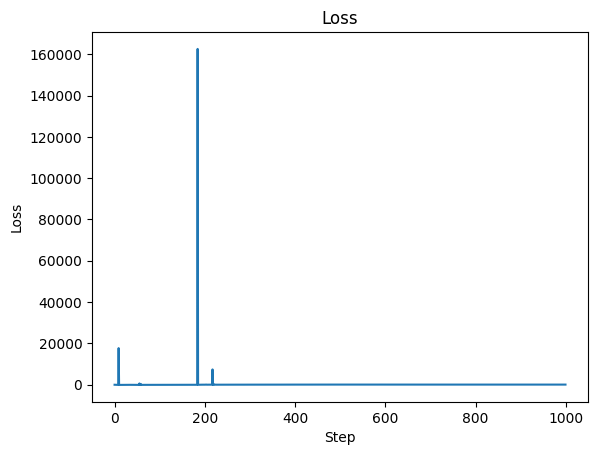

In [255]:
plt.plot(loss_arr_dist)
plt.title('Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

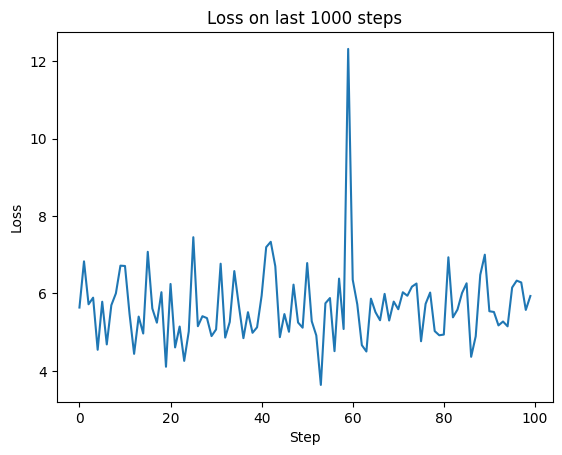

In [256]:
plt.plot(loss_arr_dist[-100:])
plt.title('Loss on last 1000 steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [261]:
# Inference

# Sample points from warped space
with torch.no_grad():
  z_0 = proposal.sample(10000).squeeze()

# Apply HMC to points from warped space
chains = HMC(
            z_0,
            target,
            N_SAMPLES,
            BURN_IN,
            step_size = 0.3,
            num_leapfrog_steps = 7,
            verbose = False,
          )

# Apply RealNVP to chains and get final samples
with torch.no_grad():
  chains = chains.float()
  chains_no_grad = chains.detach().float()
  z = nfm.forward(chains_no_grad)

Sample: 100%|██████████| 1/1 [00:01,  1.21s/it, step size=7.50e-02, acc. prob=0.000]


In [262]:
z

tensor([[[ 0.8157,  0.8785, -0.6003,  ...,  1.0607, -1.1877, -1.8949],
         [ 1.0107,  1.3726,  1.7956,  ..., -0.4919, -2.2254,  2.1633],
         [ 1.1287,  1.5784,  2.3567,  ..., -0.4375,  2.2239, -3.6221],
         ...,
         [ 1.0062,  1.6648, -0.8060,  ..., -0.5121, -0.8239,  0.4796],
         [ 1.0691, -1.1229, -1.0098,  ...,  2.2184,  0.4303,  1.7662],
         [ 0.5315, -0.3009,  1.5879,  ...,  0.5847, -0.0820,  2.4762]]])

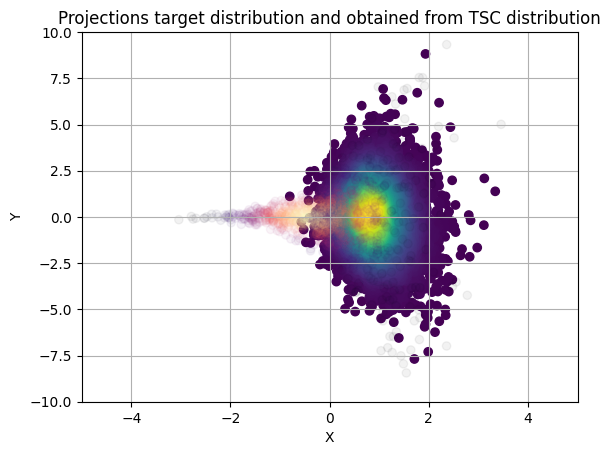

In [263]:
numpy_array = z.squeeze().detach().numpy()
# numpy_array = np.nan_to_num(numpy_array_, nan=0.0, posinf=0.0, neginf=0.0)

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Projections target distribution and obtained from TSC distribution')
ax.grid(True)
visualize_dist_(numpy_array, ax)
visualize_dist_nf(target, ax=ax, s=1000, nf = None, alpha=0.05, cmap="magma")
ax.set_xlim(-5, 5)  # Adjust the limits as needed
ax.set_ylim(-10, 10)  # Adjust the limits as needed
plt.show()

In [265]:
# Calculate metrics

true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(), # True samples [num of samples, dim]
                      z.transpose(0,1).numpy(), # Generated samples [num_of_samples, num of chains, dim]
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.169, Std: 0.003. 
ESS: 1.000 
EMD: 300.669


In [266]:
metrics

{'ess': 1.0,
 'tv_mean': Array(0.1694204, dtype=float32),
 'tv_conf_sigma': Array(0.00257811, dtype=float32),
 'emd': 300.66946557401076}

### dim=100

In [282]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 100 # Dimension

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1
BURN_IN = 0
device="cpu"

In [283]:
# Define target and proposal

target =  Funnel(num_dims=dim)
proposal = nf.distributions.base.GaussianMixture(n_modes = 2, dim = latent_size, trainable=True)

In [284]:
# Define layers of RealNVP

K = 3
b = torch.Tensor([1] * (latent_size // 2) + [0] * (latent_size // 2))
flows = []
for g in range(K):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    if g % 2 == 0:
      flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
      flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
nfm = nf.NormalizingFlow(proposal, flows, target)

In [285]:
# Define optimizer and scheduler

optimizer_t = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_t = StepLR(optimizer_t, 1, gamma=1e-4)

In [286]:
# Training

torch.manual_seed(296)
n_iter = 1000

# magic params for loss
num_samples = 2 * 10
anneal_iter = 500

loss_arr_dist = []

for i in tqdm(range(n_iter)):

    optimizer_t.zero_grad()

    # Sample a point from warped space
    if i % 50 == 0:
      z_0 = proposal.sample(N_CHAINS).squeeze()

    # Apply HMC to this point in warped space
    chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size = 0.1,
                  num_leapfrog_steps = 10,
                  verbose = False,
                )
    chains = chains.float()
    chains_no_grad = chains.detach().float()

    # Apply RealNVP to the chain and get the final sample
    z = nfm.forward(chains_no_grad)

    if (i % 99 == 0):
      print("Scale:", proposal.log_scale)
      print("Loc:", proposal.loc)

    # Calculate loss
    loss_t = nfm.reverse_kld(num_samples, beta=np.min([1., 0.01 + i / anneal_iter]))
    loss_t.backward(retain_graph=True)

    # Return back to warped space
    z_0 = nfm.inverse(z).squeeze()
    optimizer_t.step()

    loss_arr_dist.append(loss_t.detach().item())

  0%|          | 0/1000 [00:00<?, ?it/s]

Sample: 100%|██████████| 1/1 [00:00, 37.34it/s, step size=4.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]], requires_grad=True)
Loc: Parameter containing:
tensor([[[ 0.4803,  

Sample: 100%|██████████| 1/1 [00:00, 70.49it/s, step size=4.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-1.7698e-02,  5.2424e-03,  1.1479e-02,  3.0929e-02,  7.8566e-04,
           2.8834e-02,  4.1348e-03,  2.2195e-02,  2.1042e-02,  7.9639e-04,
           1.0746e-02,  1.0783e-02,  1.5016e-02,  2.4872e-02,  2.6312e-02,
           8.5952e-03,  4.7227e-03,  8.0176e-03,  5.1263e-03,  6.6228e-03,
          -2.1822e-03,  9.7326e-03,  1.0026e-02,  6.1288e-03,  2.7533e-02,
           1.3416e-02,  3.4639e-03,  2.7586e-03,  1.9775e-02,  4.7954e-03,
           1.9007e-02,  5.0139e-03,  3.1491e-03,  3.7348e-02,  1.5750e-02,
           3.3307e-03,  3.6061e-03, -2.0272e-03,  4.1876e-04,  2.3799e-02,
           3.3425e-04,  1.2617e-02,  8.2525e-03,  9.2267e-03,  1.4219e-02,
           9.3443e-06,  6.2704e-03,  1.9746e-02,  9.3386e-03,  3.9556e-02,
           1.2947e-02,  1.0406e-02,  4.8323e-03,  2.2535e-02,  7.5889e-03,
          -1.5164e-03,  1.8296e-02,  4.3469e-03, -7.1428e-03,  4.7264e-03,
           1.1138e-02,  5.4647e-03,  1.0458e-02,  1.9070e-02,  5.2213e-

Sample: 100%|██████████| 1/1 [00:00, 41.90it/s, step size=4.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-2.3145e-02,  1.1263e-02,  1.0518e-02,  3.0715e-02,  9.1036e-04,
           4.0796e-02,  4.8281e-03,  1.6537e-02,  3.5787e-02,  6.9601e-03,
           1.0856e-02,  2.3783e-02,  8.2858e-03,  3.1988e-02,  2.0868e-02,
           1.0328e-02,  4.8638e-03, -3.9736e-03,  4.1196e-03,  6.7544e-03,
           7.3306e-03,  1.9725e-02,  1.4132e-03,  6.3151e-03,  4.7170e-02,
           1.0296e-02,  8.3661e-03, -2.2762e-03,  1.9762e-02,  4.8306e-03,
           4.4569e-02,  1.0213e-02,  8.2278e-03,  4.7546e-02,  2.3892e-02,
           1.9084e-03,  1.6229e-02,  5.7695e-04,  1.3096e-02,  1.4840e-02,
           1.6388e-03,  1.7962e-02,  9.5778e-03,  1.1798e-02,  1.2401e-02,
           2.6957e-03,  2.6343e-02,  1.2646e-02,  8.7986e-03,  4.0668e-02,
           3.5423e-03,  9.6952e-03, -4.0949e-04,  2.5854e-02,  1.7407e-02,
          -2.5574e-03,  9.9641e-03,  1.9326e-03, -1.9000e-02,  1.6773e-03,
           1.4202e-02,  5.5536e-03,  1.1994e-02,  1.8647e-02,  6.5344e-

Sample: 100%|██████████| 1/1 [00:00, 60.93it/s, step size=4.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-2.5097e-02,  1.6002e-02,  1.0560e-02,  3.7413e-02,  2.5850e-03,
           4.0847e-02,  1.1422e-02,  2.1728e-02,  4.4491e-02,  1.2585e-02,
           1.0926e-02,  3.1289e-02,  1.0116e-02,  4.4333e-02,  2.4416e-02,
           2.0643e-02,  5.4077e-03, -2.4218e-03,  4.9296e-03,  8.3955e-03,
           9.2545e-03,  2.4335e-02,  3.4219e-03,  1.2633e-02,  5.2234e-02,
           1.3073e-02,  1.7820e-02, -3.0493e-03,  1.9851e-02,  1.7234e-02,
           5.3311e-02,  1.3692e-02,  1.6293e-02,  5.6608e-02,  3.1712e-02,
           2.9619e-03,  2.5197e-02,  2.1518e-03,  1.9609e-02,  1.8600e-02,
           8.2696e-03,  2.2074e-02,  1.4455e-02,  1.8708e-02,  1.2187e-02,
           4.3451e-03,  3.5069e-02,  1.2610e-02,  1.1236e-02,  4.5010e-02,
           4.5989e-03,  1.3933e-02,  2.5787e-03,  2.8151e-02,  2.4853e-02,
          -3.2271e-03,  5.9156e-03,  3.1691e-03, -1.7848e-02,  4.4484e-04,
           1.7537e-02,  5.4326e-03,  1.2297e-02,  1.7985e-02,  4.6976e-

Sample: 100%|██████████| 1/1 [00:00, 36.60it/s, step size=4.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-2.7990e-02,  1.9633e-02,  1.1483e-02,  4.6368e-02,  4.4789e-04,
           4.5126e-02,  1.4836e-02,  2.8267e-02,  5.6446e-02,  1.6665e-02,
           1.1160e-02,  3.1987e-02,  1.1699e-02,  4.8344e-02,  2.9201e-02,
           2.7728e-02,  6.3208e-03,  3.1855e-04,  7.2773e-03,  8.9286e-03,
           1.8402e-02,  2.8738e-02,  9.5381e-03,  1.9448e-02,  5.4269e-02,
           1.3916e-02,  2.2410e-02, -3.9482e-03,  2.1945e-02,  3.2286e-02,
           6.1545e-02,  9.1263e-03,  1.7400e-02,  5.7452e-02,  4.0423e-02,
           5.5714e-03,  3.5420e-02,  3.8509e-03,  1.8250e-02,  2.5754e-02,
           7.2166e-03,  2.4228e-02,  1.2817e-02,  2.3315e-02,  1.5242e-02,
           5.8776e-03,  3.5326e-02,  1.3215e-02,  9.8042e-03,  4.9087e-02,
           4.7192e-03,  1.2647e-02, -2.7182e-04,  2.1705e-02,  1.8810e-02,
          -2.1764e-03,  5.2981e-03,  3.8263e-03, -1.9219e-02,  5.7011e-04,
           1.8078e-02,  5.1459e-03,  1.2812e-02,  1.6594e-02,  5.4911e-

Sample: 100%|██████████| 1/1 [00:00, 68.94it/s, step size=4.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-2.9152e-02,  2.3424e-02,  1.2002e-02,  5.3430e-02, -1.3946e-03,
           5.0791e-02,  1.7744e-02,  2.3423e-02,  6.8799e-02,  2.0750e-02,
           1.1352e-02,  3.9822e-02,  1.2883e-02,  5.2593e-02,  3.3046e-02,
           3.6134e-02,  6.3786e-03,  1.8142e-03,  8.3075e-03,  9.4393e-03,
           1.6617e-02,  3.3954e-02,  1.2682e-02,  2.7026e-02,  5.7353e-02,
           1.5138e-02,  2.5271e-02, -2.5854e-03,  2.3791e-02,  4.1092e-02,
           6.7781e-02,  1.0527e-02,  1.9758e-02,  6.4529e-02,  4.6762e-02,
           7.3497e-03,  3.8231e-02,  4.8565e-03,  2.3187e-02,  3.4945e-02,
           1.4058e-02,  2.1176e-02,  1.2152e-02,  2.8649e-02,  1.5420e-02,
           7.6360e-03,  4.0655e-02,  1.3554e-02,  8.5804e-03,  4.7625e-02,
           3.8877e-03,  1.1784e-02, -1.5427e-03,  1.8685e-02,  1.4421e-02,
          -3.2965e-03,  4.8961e-03,  4.0287e-03, -1.9597e-02, -6.3936e-04,
           1.7563e-02,  5.1296e-03,  1.1714e-02,  1.5250e-02,  4.2579e-

Sample: 100%|██████████| 1/1 [00:00, 59.72it/s, step size=4.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.0417e-02,  2.9269e-02,  1.2002e-02,  6.0473e-02, -1.4936e-03,
           5.8015e-02,  1.9518e-02,  2.0925e-02,  8.1551e-02,  2.6271e-02,
           1.1319e-02,  4.2829e-02,  1.2144e-02,  5.4664e-02,  3.6888e-02,
           4.5154e-02,  5.8184e-03,  2.4815e-03,  7.9535e-03,  9.9717e-03,
           1.1479e-02,  3.9524e-02,  1.4164e-02,  3.5583e-02,  5.0864e-02,
           1.6256e-02,  2.7082e-02, -3.9278e-03,  2.5061e-02,  4.9824e-02,
           7.6887e-02,  1.0353e-02,  2.2136e-02,  6.6690e-02,  5.3167e-02,
           7.5230e-03,  4.3583e-02,  6.1317e-03,  2.9035e-02,  4.3311e-02,
           1.8753e-02,  1.8945e-02,  5.1399e-03,  2.8997e-02,  1.4863e-02,
           8.6394e-03,  4.6868e-02,  1.3132e-02,  7.6584e-03,  4.6095e-02,
           2.3214e-03,  1.0388e-02, -4.3562e-03,  1.3830e-02,  1.2548e-02,
          -4.9876e-03,  2.5953e-03,  3.7127e-03, -2.0840e-02, -1.6953e-03,
           1.6431e-02,  4.7696e-03,  1.2178e-02,  1.3245e-02,  2.3702e-

Sample: 100%|██████████| 1/1 [00:00, 56.66it/s, step size=2.00e-01, acc. prob=0.944]


Scale: Parameter containing:
tensor([[[-3.1417e-02,  3.4588e-02,  1.1608e-02,  6.7920e-02, -3.4286e-03,
           6.3437e-02,  2.0907e-02,  1.8869e-02,  8.6443e-02,  3.0311e-02,
           1.1218e-02,  3.7772e-02,  1.2611e-02,  5.3373e-02,  4.1636e-02,
           5.2712e-02,  5.1580e-03,  2.8170e-03,  7.9912e-03,  1.0216e-02,
           1.0074e-02,  4.2605e-02,  1.5802e-02,  4.4408e-02,  4.4213e-02,
           1.7481e-02,  2.7772e-02, -4.5797e-03,  2.3990e-02,  5.2806e-02,
           8.6181e-02,  4.5115e-03,  2.2255e-02,  7.0303e-02,  5.6274e-02,
           7.0602e-03,  4.6928e-02,  7.4170e-03,  2.9999e-02,  5.2225e-02,
           2.2070e-02,  1.5569e-02, -1.5006e-03,  2.6789e-02,  1.4250e-02,
           1.0066e-02,  4.7726e-02,  1.2612e-02,  6.3679e-03,  4.2031e-02,
           1.6049e-03,  1.0402e-02, -5.0505e-03,  1.1379e-02,  1.4740e-02,
          -6.3323e-03,  1.6888e-03,  3.6161e-03, -2.1611e-02, -1.9408e-03,
           1.5891e-02,  4.6601e-03,  1.2477e-02,  1.2713e-02,  7.6806e-

Sample: 100%|██████████| 1/1 [00:00, 56.32it/s, step size=4.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.2067e-02,  4.0484e-02,  1.1300e-02,  7.3489e-02, -5.4913e-03,
           6.6934e-02,  2.2463e-02,  1.7358e-02,  8.5351e-02,  3.4642e-02,
           1.1047e-02,  3.4536e-02,  1.2830e-02,  5.4436e-02,  4.5952e-02,
           5.8899e-02,  4.7213e-03,  2.8533e-03,  7.4251e-03,  1.0117e-02,
           7.2703e-03,  4.5190e-02,  1.6345e-02,  5.2567e-02,  3.5600e-02,
           1.7206e-02,  2.7141e-02, -4.8964e-03,  2.2309e-02,  5.2058e-02,
           9.2545e-02,  3.2768e-03,  2.0776e-02,  7.3940e-02,  5.8896e-02,
           6.3674e-03,  5.0148e-02,  8.5122e-03,  2.7121e-02,  5.9915e-02,
           2.2471e-02,  1.1235e-02, -6.8720e-03,  2.2068e-02,  1.3806e-02,
           1.0994e-02,  4.6541e-02,  1.1844e-02,  5.4343e-03,  3.9278e-02,
           9.6195e-04,  8.4621e-03, -5.8847e-03,  8.6999e-03,  1.8982e-02,
          -7.1315e-03,  1.2590e-03,  3.5411e-03, -2.1504e-02, -2.2554e-03,
           1.5265e-02,  4.4144e-03,  1.3505e-02,  1.2733e-02,  1.0632e-

Sample: 100%|██████████| 1/1 [00:00, 65.23it/s, step size=4.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.2487e-02,  4.4031e-02,  1.1180e-02,  7.8142e-02, -7.4965e-03,
           6.6027e-02,  2.1335e-02,  1.4960e-02,  8.5864e-02,  3.6538e-02,
           1.0902e-02,  3.3166e-02,  1.3610e-02,  4.6387e-02,  5.0679e-02,
           6.4591e-02,  4.2948e-03,  1.9304e-03,  7.2311e-03,  9.3660e-03,
           5.3624e-03,  4.7316e-02,  1.7174e-02,  6.1054e-02,  3.1671e-02,
           1.7663e-02,  2.6459e-02, -5.3261e-03,  1.9362e-02,  5.0896e-02,
           9.9528e-02,  6.0634e-04,  1.8258e-02,  7.4035e-02,  6.0731e-02,
           5.8450e-03,  5.1121e-02,  9.0553e-03,  2.6349e-02,  6.6245e-02,
           2.4386e-02,  1.1533e-02, -1.1132e-02,  2.0170e-02,  1.2131e-02,
           1.1549e-02,  4.6932e-02,  1.1437e-02,  3.3765e-03,  3.8380e-02,
           1.1844e-03,  8.4734e-03, -5.3735e-03,  8.0277e-03,  2.0768e-02,
          -7.4429e-03,  8.9817e-04,  3.6080e-03, -2.1448e-02, -2.3246e-03,
           1.6396e-02,  4.3379e-03,  1.2872e-02,  1.2199e-02,  1.6226e-

Sample: 100%|██████████| 1/1 [00:00, 39.13it/s, step size=4.00e-01, acc. prob=0.000]


Scale: Parameter containing:
tensor([[[-3.3189e-02,  4.7536e-02,  1.0714e-02,  8.2158e-02, -1.0281e-02,
           6.6323e-02,  2.1639e-02,  1.5486e-02,  8.5242e-02,  3.7493e-02,
           1.0810e-02,  2.8932e-02,  1.4273e-02,  4.4587e-02,  5.4185e-02,
           6.8112e-02,  3.9575e-03,  1.1955e-03,  6.5773e-03,  8.8257e-03,
           3.6735e-03,  4.3771e-02,  1.6909e-02,  6.8636e-02,  2.7479e-02,
           1.7224e-02,  2.4360e-02, -6.4480e-03,  1.6012e-02,  4.6530e-02,
           1.0012e-01, -4.3955e-03,  1.4456e-02,  7.2042e-02,  6.1910e-02,
           5.0596e-03,  5.2791e-02,  9.3083e-03,  2.2461e-02,  7.2955e-02,
           2.3146e-02,  9.7996e-03, -1.3347e-02,  1.7124e-02,  9.3190e-03,
           1.1464e-02,  4.6862e-02,  1.0730e-02,  1.8299e-03,  3.6725e-02,
           1.1301e-03,  1.0400e-02, -4.0450e-03,  5.8089e-03,  2.7234e-02,
          -7.8937e-03,  7.0407e-04,  4.2677e-03, -2.0284e-02, -2.4636e-03,
           1.7222e-02,  4.2659e-03,  1.2499e-02,  1.2720e-02,  6.4310e-

Sample: 100%|██████████| 1/1 [00:00, 54.58it/s, step size=4.00e-01, acc. prob=0.000]


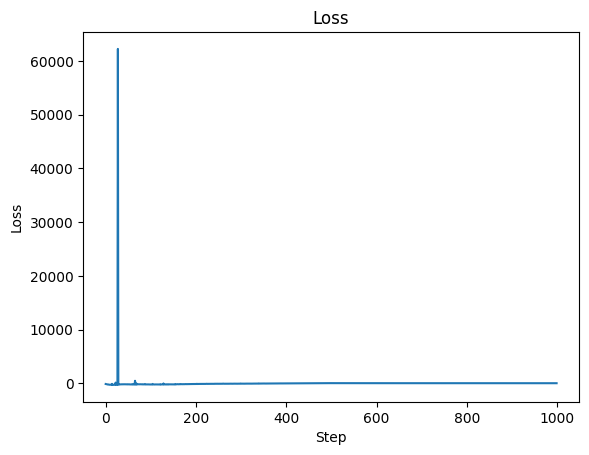

In [287]:
plt.plot(loss_arr_dist)
plt.title('Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

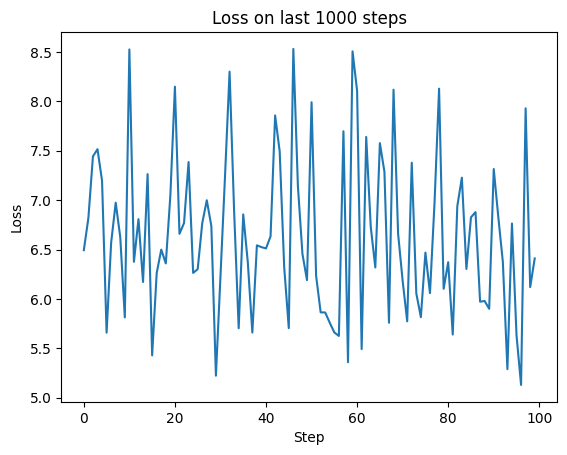

In [288]:
plt.plot(loss_arr_dist[-100:])
plt.title('Loss on last 1000 steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [289]:
# Inference

# Sample points from warped space
with torch.no_grad():
  z_0 = proposal.sample(10000).squeeze()

# Apply HMC to points from warped space
chains = HMC(
            z_0,
            target,
            N_SAMPLES,
            BURN_IN,
            step_size = 0.3,
            num_leapfrog_steps = 7,
            verbose = False,
          )

# Apply RealNVP to chains and get final samples
with torch.no_grad():
  chains = chains.float()
  chains_no_grad = chains.detach().float()
  z = nfm.forward(chains_no_grad)

Sample: 100%|██████████| 1/1 [00:03,  3.13s/it, step size=7.50e-02, acc. prob=0.000]


In [290]:
z

tensor([[[ 1.1901, -1.6727, -2.2755,  ..., -0.8648, -0.3389, -0.9589],
         [ 1.2691,  1.5239, -1.0354,  ...,  1.0838, -0.2760,  2.6125],
         [ 1.1883,  2.5546, -2.6976,  ..., -3.3056,  2.1267,  0.9898],
         ...,
         [ 0.8363,  0.2361,  0.5933,  ..., -0.3805,  1.8985,  3.0137],
         [ 0.8645, -1.7312,  2.1444,  ..., -1.5378,  0.0473,  0.5712],
         [ 1.3061, -2.9776, -1.2554,  ..., -3.3454, -1.4759, -0.6182]]])

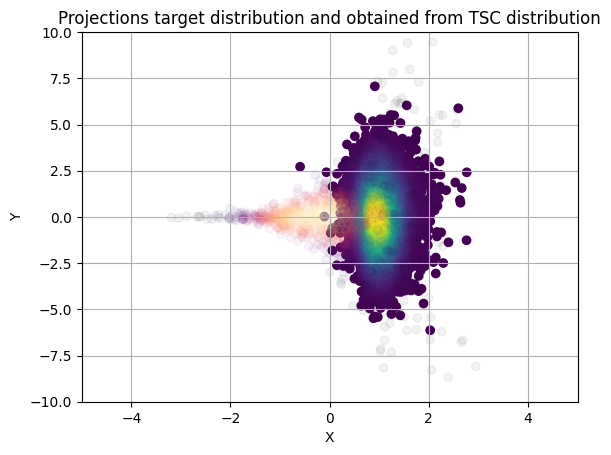

In [291]:
numpy_array = z.squeeze().detach().numpy()
# numpy_array = np.nan_to_num(numpy_array_, nan=0.0, posinf=0.0, neginf=0.0)

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Projections target distribution and obtained from TSC distribution')
ax.grid(True)
visualize_dist_(numpy_array, ax)
visualize_dist_nf(target, ax=ax, s=1000, nf = None, alpha=0.05, cmap="magma")
ax.set_xlim(-5, 5)  # Adjust the limits as needed
ax.set_ylim(-10, 10)  # Adjust the limits as needed
plt.show()

In [292]:
# Calculate metrics

true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(), # True samples [num of samples, dim]
                      z.transpose(0,1).numpy(), # Generated samples [num_of_samples, num of chains, dim]
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.180, Std: 0.003. 
ESS: 1.000 
EMD: 694.423


In [293]:
metrics

{'ess': 1.0,
 'tv_mean': Array(0.17994387, dtype=float32),
 'tv_conf_sigma': Array(0.00266767, dtype=float32),
 'emd': 694.4226445219732}